In [1]:
code_dir = "../UXO_protected/+BTInvertPY"

In [2]:
import numpy as np
import os
import h5py
import pandas as pd
from scipy import stats
import torch

import matplotlib.pyplot as plt
from matplotlib import cm as cmap
from matplotlib import colors
from matplotlib.colors import Normalize
from mpl_toolkits import mplot3d

import uxo_utils
from uxo_utils import (
    SensorInfo, Model, preCalcLoopCorners, FModParam, 
    forwardWithQ, sensorCoords2RxCoords, hprimary, formQmatrix
)

In [3]:
from matplotlib import rcParams
rcParams['font.size'] = 14
np.random.seed(2020)
torch.manual_seed(13)

## load sensor info and ordnance data

In [4]:
sensorinfo = uxo_utils.load_sensor_info()
ordnance = uxo_utils.load_ordnance_dict()

In [5]:
ordnance.keys()

dict_keys(['105mm', '2.36-in', '2.75-in', '2.95-in', '20-lb Bomb', '25-lb Bomb', '3-in', '3.5-in', '30mm', '37mm', '4-in', '4-in Sphere', '4.2-in', '4.5-in', '4.52-in', '5-lb Bomb', '57mm', '60mm', '66mm', '75mm', '76mm', '81mm', '90mm', '106mm', 'ISO Large', 'ISO Medium', 'ISO Small', '2.25-in', '10-lb Bomb', '100-lb Bomb', 'Booster', 'Fuze', '120mm', 'Grenade', '152mm', 'Igniter Bomb', 'Landmine', 'Livens Projectile', 'Depth Charge', 'Parachute Flare', 'Rifle Grenade', '155mm', 'Dual Mode HE Rocket', 'Smoke Pot', 'Underwater Mine', '16-in', '175mm', 'Rocket Motor', '20mm', '250-lb Bomb', '25mm', '35mm', '40mm', '105mm SABOT', '5-in', '50 cal', '6-in', '7.2-in Depth Charge', '8-in', 'Bomblet', 'Booster Cup'])

## set up survey parameters
- x is cross-line
- y is inline

In [6]:
ntx = len(sensorinfo.transmitters)
ymax = 3. 
y_spacing = 0.2
dy = y_spacing / ntx
nloc = int(ymax/dy)
ncycles = int(nloc/ntx)

y = np.linspace(0, ymax-dy, nloc)
x = np.zeros(nloc)
z = 0.28 * np.ones(nloc)

pitch = np.zeros(nloc)
roll = np.zeros(nloc)
yaw = np.zeros(nloc)  # moving north (sensor in typical orientation)

txnum = np.kron(np.ones(ncycles), np.arange(ntx))

In [7]:
pitch.shape

(75,)

In [8]:
# Convert sensor location coordinates to Rx locations
pos, mnum = sensorCoords2RxCoords(
    sensorinfo=sensorinfo,
    x = x, 
    y = y, 
    z = z, 
    pitch = pitch, 
    roll = roll, 
    yaw = yaw,
    txnum = txnum
)

pitch = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(pitch)])
roll = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(roll)])
yaw = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(yaw)])
pos = np.concatenate(pos,axis=0)

In [9]:
pitch.shape

(2475,)

In [10]:
for i in range(3):
    print(pos[:, i].min(), pos[:, i].max())

-1.0 1.0
-0.25 3.21
0.28 0.28


In [11]:
nloc

75

# ordnance objects

In [12]:
times = ordnance["ISO Small"]["times"]

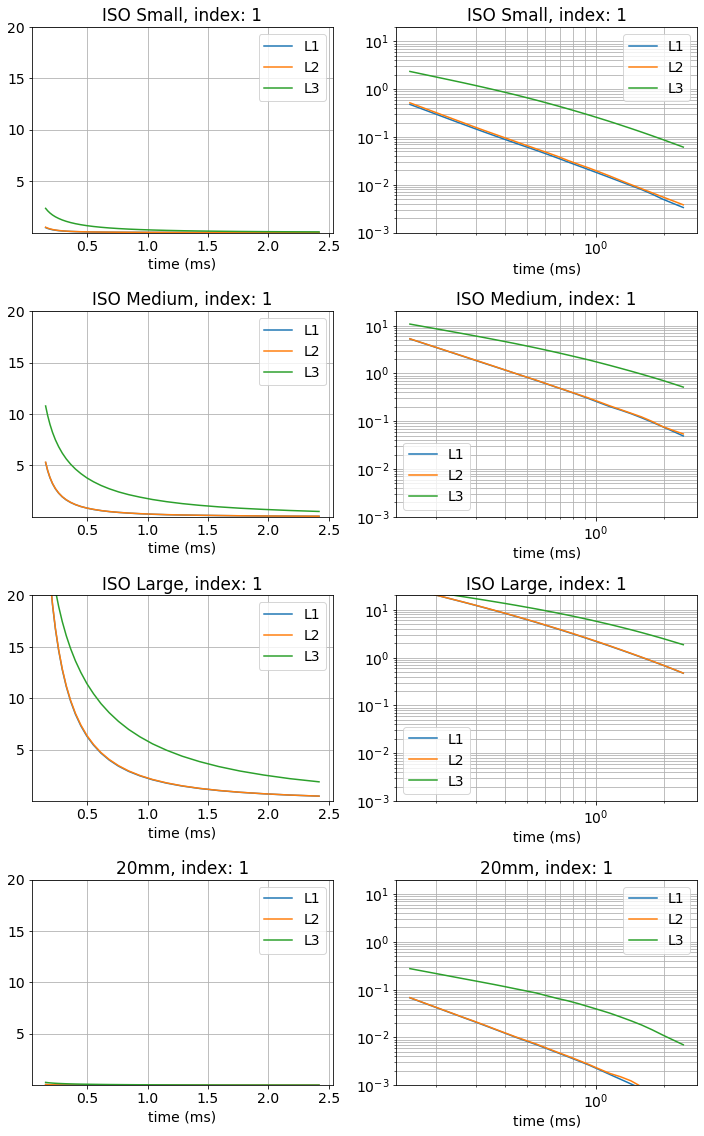

In [13]:
plot_me = {
    "ISO Small": 1,
    "ISO Medium": 1,
    "ISO Large": 1,
    "20mm": 1
}
fig, ax = plt.subplots(len(plot_me.keys()), 2, figsize=(10, 4*len(plot_me.keys())))

for i, key in enumerate(plot_me.keys()):
    for l in ["L1", "L2", "L3"]:
        L = ordnance[key][l][plot_me[key]]
        ax[i, 0].plot(times, L, label=l)
        ax[i, 1].loglog(times, L, label=l)

    for a in ax[i, :]:
        a.set_title(f"{key}, index: {1}")
        a.grid(which="both")
        a.legend()
        a.set_xlabel("time (ms)")
        a.set_ylim([1e-3, 20])
        
plt.tight_layout()

# ranges of parameters

In [14]:
depth_ranges = [
    np.r_[0, 0.5], 
    np.r_[0, 0.5],
    np.r_[0, 0.5],
    np.r_[0, 0.5],
]

x_range = np.r_[-1.25, 1.25]
y_range = np.r_[0., ymax]

yaw_range = np.r_[0, 2*np.pi]
pitch_range = np.r_[0, 2*np.pi]
roll_range = np.r_[0, 2*np.pi]

noise_amplitudes = np.r_[1e-5, 1e-1]

def generate_random_variables(n, bounds, log_scaled=False):
    if log_scaled is True:
        if any(bounds == 0):
            return np.zeros(n)
        bounds = np.log(bounds)
        return np.exp(bounds.min() + (bounds.max() - bounds.min()) * np.random.rand(n))
    return bounds.min() + (bounds.max() - bounds.min()) * np.random.rand(n)

In [15]:
noise_test_plot = np.load("noise_test_plot.npz")

In [16]:
# arrange the data by mn ind
noise_test_plot["data"].shape
noise_test_plot_mn = [noise_test_plot["data"][:, noise_test_plot["mn"] == i+1] for i in range(mnum.max()+1)]

In [17]:
len(noise_test_plot_mn)

165

In [18]:
ntrain = 2048*4
ntest = 1024
nvalid = 1024

class_dict = {
    0: "not TOI",
    1: "ISO Small",
    2: "ISO Medium", 
    3: "ISO Large",
    4: "clutter",
}
n_class = len(class_dict.keys())

clutter_dict = {
#     0: "30mm",
    0: "20mm",
#     2: "ISO Small Plate",
    1: "ISO Small Sphere",
#     4: "Grenade"
}

In [19]:
labels_train = np.random.choice(n_class, ntrain)
labels_test = np.random.choice(n_class, ntest)
labels_valid = np.random.choice(n_class, nvalid)

def generate_parameters(labels):
    n = len(labels)
    
    depths = np.zeros(n)
    
    x = generate_random_variables(n, x_range)
    y = generate_random_variables(n, y_range)

    yaw = generate_random_variables(n, yaw_range)
    pitch = generate_random_variables(n, pitch_range)
    roll = generate_random_variables(n, roll_range)
    
    noise_amplitude = generate_random_variables(n, noise_amplitudes, True)
    
    polarizations = np.zeros(n, dtype=int)
    clutter = np.zeros(n, dtype=int)
    
    for i in np.unique(labels):
        ii = labels == i  # indices of the labels
        
        if class_dict[i] != "not TOI":
            depths[ii] = generate_random_variables(ii.sum(), depth_ranges[i-1])
            
            if class_dict[i] == "clutter":
                j = np.random.choice(len(clutter_dict.keys()), ii.sum())
                clutter[ii] = j
                for key, val in clutter_dict.items():
                    jj = j == key
                    if val == "30mm" or val == "20mm":
                        polarizations[ii][jj] = np.ones(jj.sum())
                    else: 
                        polarizations[ii][jj] = np.random.choice(len(ordnance["ISO Small"]["L3"]), jj.sum())
            else:
                polarizations[ii] = np.random.choice(len(ordnance[class_dict[i]]["L3"]), ii.sum())
                                 
    
    return pd.DataFrame({
        "label": labels,
        "depth": depths,
        "x": x,
        "y": y,
        "z": -depths,
        "yaw": yaw,
        "pitch": pitch,
        "roll": roll, 
        "noise_amplitude": noise_amplitude,
        "polarizations": polarizations,
        "clutter_type": clutter
    })

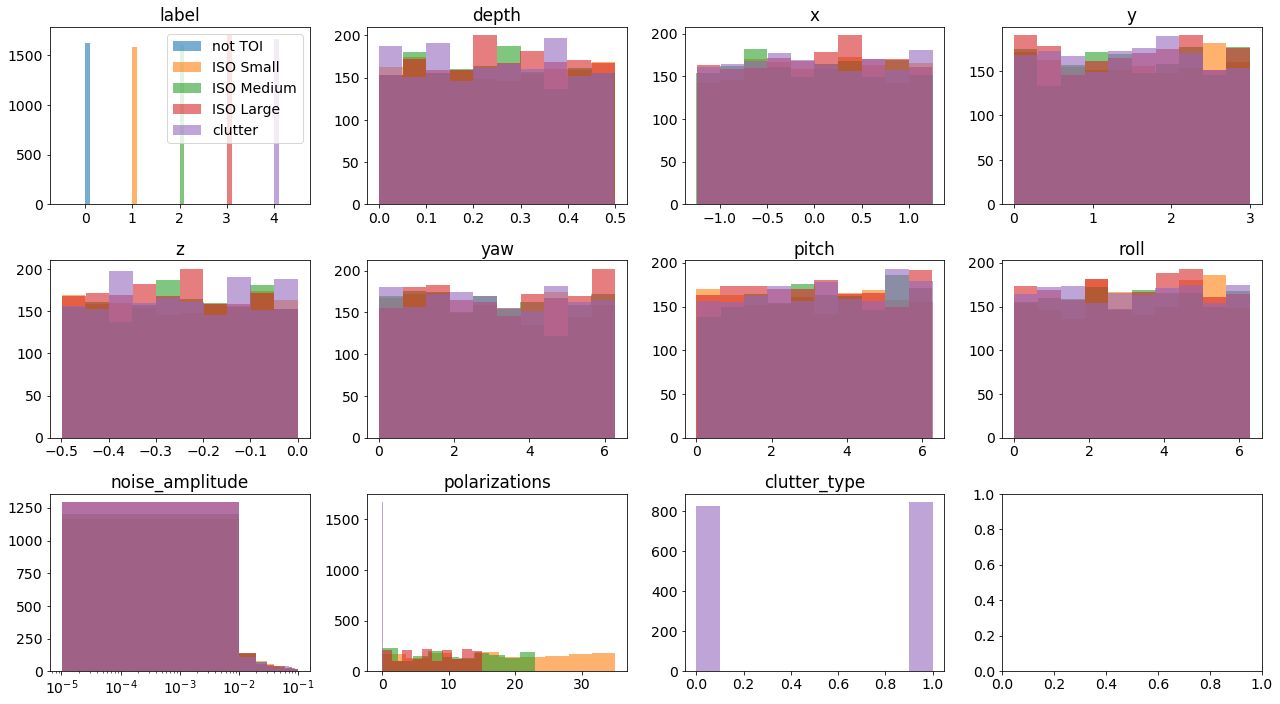

In [20]:
params_train = generate_parameters(labels_train) 
params_test = generate_parameters(labels_test) 
params_valid = generate_parameters(labels_valid) 

fig, ax = plt.subplots(3, 4, figsize=(18, 10))
ax = ax.flatten()

i = 0
for key, val in params_train.items():
    for j in range(n_class):
        inds = labels_train == j
        if key != "label" and j == 0: 
            pass  # these parameters are irrelevant if there is no object
        elif key == "noise_amplitude":
            ax[i].hist(val[inds], 10, color=f"C{j}", alpha=0.6)
            ax[i].set_xscale("log")
        elif (key == "clutter_type") and (j == n_class-1):
            ax[i].hist(val[inds], 10, color=f"C{j}", alpha=0.6)
        elif key != "clutter_type":
            ax[i].hist(val[inds], 10, color=f"C{j}", alpha=0.6)
    ax[i].set_title(key)
    i += 1

ax[0].legend(list(class_dict.values()))
plt.tight_layout()

# set up forward simulations

In [21]:
def noise_model(times, amplitude=0.1, slope=-1, intercept=-0.5):
    return amplitude * np.exp(slope * np.log(times) + intercept)

In [22]:
# figuring out where all of the vertices are in coordinate system -- gives us location of vertices 
Tx_indices_rot, Rx_indices_rot = preCalcLoopCorners(
    sensorinfo=sensorinfo, mnum=mnum, rlist=pos, pitch=pitch, roll=roll, yaw=yaw
) 

# convienence object for inputs to fwd modelling 
st = FModParam(sensorinfo, pos, mnum, times, Tx_indices_rot, Rx_indices_rot)  

In [23]:
def run_simulations(parameters, st=st, mnum=mnum, ncycles=ncycles):
    data = []
    noise_data = []
    for i, l in enumerate(parameters["label"]):
        if l == 0:
            # this can later be replaced with random noise or other structured but uninteresting signal
            V = np.zeros((mnum.max()+1, ncycles, len(times)))
#             for j in range(mnum.max()+1):
#                 mnum_noise = np.random.choice(mnum.max(), 1)[0]
#                 d = noise_test_plot_mn[mnum_noise]
#                 i_start = np.random.choice(d.shape[1], 1)[0]
#                 if i_start > d.shape[1] - ncycles:
#                     V[j, :, :] = np.hstack([
#                         d[:, i_start:], 
#                         np.fliplr(d[:, -(ncycles - (d.shape[1]-i_start)):])
#                     ]).T
#                 else: 
#                     V[j, :, :] = d[:, i_start:i_start+ncycles].T
        else: 
            xyz = np.r_[parameters["x"][i], parameters["y"][i], parameters["z"][i]]
            ypr = np.r_[parameters["yaw"][i], parameters["pitch"][i], parameters["roll"][i]]
            pi = parameters["polarizations"][i]
            
            if class_dict[l] != "clutter":
                L3 = ordnance[class_dict[l]]["L3"][pi]
                L2 = ordnance[class_dict[l]]["L2"][pi]
                L1 = ordnance[class_dict[l]]["L1"][pi]
            else:
                clutter_type = parameters["clutter_type"][i]
                clutter_name = clutter_dict[clutter_type]
                if clutter_name in ["30mm", "20mm"]:
                    L3 = ordnance[clutter_name]["L3"][pi]
                    L2 = ordnance[clutter_name]["L2"][pi]
                    L1 = ordnance[clutter_name]["L1"][pi]
                elif clutter_name == "ISO Small Plate":
                    L3 = ordnance["ISO Small"]["L3"][pi]
                    L2 = ordnance["ISO Small"]["L3"][pi] # L2 == L3 is like a plate
                    L1 = ordnance["ISO Small"]["L1"][pi]
                elif clutter_name == "ISO Small Sphere":
                    L3 = ordnance["ISO Small"]["L1"][pi]
                    L2 = ordnance["ISO Small"]["L1"][pi] # L1 == L2 == L3 is a sphere
                    L1 = ordnance["ISO Small"]["L1"][pi] # L1 == L2 == L3 is a sphere
                                  

            mod = Model(xyz=xyz, gba=ypr, l3=L3, l2=L2, l1=L1, times=times)
            V = forwardWithQ(mod, st) # nT/s (some version of db/dt)
            V = V.reshape(ncycles, mnum.max()+1, len(times))
            V = np.swapaxes(V, 0, 1)
        data.append(V)
        noise_data.append(
            V + 
            np.random.randn(np.prod(V.shape)).reshape(V.shape) * 
            noise_model(times, amplitude=parameters["noise_amplitude"][i])
        )
    return data, noise_data
    
    

In [24]:
%%time
data_clean_train, data_train = run_simulations(params_train)

CPU times: user 2min 21s, sys: 5.82 s, total: 2min 26s
Wall time: 37.3 s


In [25]:
%%time
data_clean_test, data_test = run_simulations(params_test)
data_clean_valid, data_valid = run_simulations(params_valid)

CPU times: user 38.5 s, sys: 2.06 s, total: 40.5 s
Wall time: 11.7 s


In [26]:
time_scaling = (times)
time_scaling

array([0.154, 0.171, 0.19 , 0.211, 0.235, 0.262, 0.292, 0.325, 0.361,
       0.401, 0.446, 0.496, 0.551, 0.613, 0.681, 0.758, 0.842, 0.936,
       1.04 , 1.156, 1.286, 1.429, 1.588, 1.764, 1.961, 2.178, 2.42 ])

In [27]:
scaled_data_train = [d*time_scaling for d in data_train]
scaled_data_test = [d*time_scaling for d in data_test]
scaled_data_valid = [d*time_scaling for d in data_valid]

In [28]:
eps = 1e-6

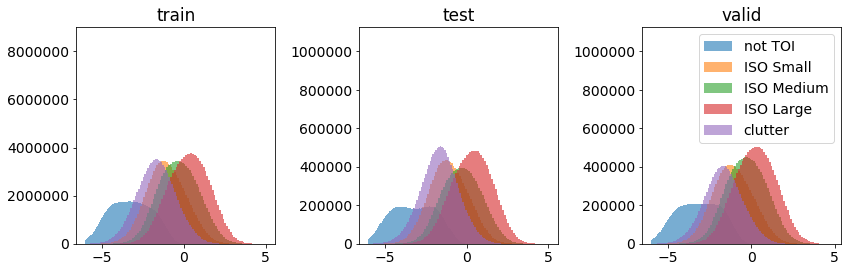

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax = ax.flatten()

for a, data, labels, title in zip(
    ax, 
    [data_train, data_test, data_valid], 
    [labels_train, labels_test, labels_valid],
    ["train", "test", "valid"]
):
    data = np.stack(data, 0)
    for j in range(n_class):
        inds = labels == j
        a.hist(np.log10(np.abs(data[inds, :, :, :]) + eps).flatten(), 100, color=f"C{j}", alpha=0.6)
        a.set_title(title)
        a.set_ylim([0, data.shape[0]*1.1e3])

ax[2].legend(list(class_dict.values()))
plt.tight_layout()

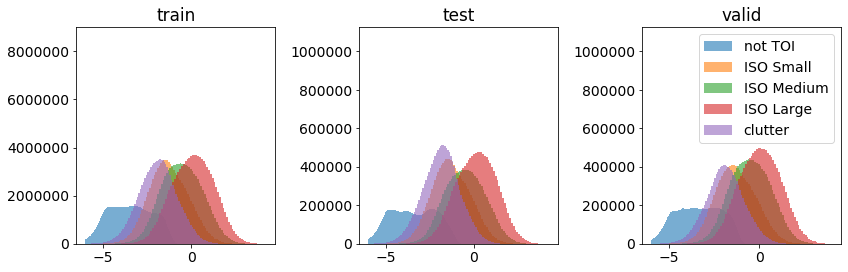

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax = ax.flatten()

for a, data, labels, title in zip(
    ax, 
    [scaled_data_train, scaled_data_test, scaled_data_valid], 
    [labels_train, labels_test, labels_valid],
    ["train", "test", "valid"]
):
    data = np.stack(data, 0)
    for j in range(n_class):
        inds = labels == j
        a.hist(np.log10(np.abs(data[inds, :, :, :])+eps).flatten(), 100, color=f"C{j}", alpha=0.6)
        a.set_title(title)
        a.set_ylim([0, data.shape[0]*1.1e3])

ax[2].legend(list(class_dict.values()))
plt.tight_layout()

In [31]:
def normalize_data(d, eps=1e-6): 
    dd = d.reshape(d.shape[0], np.prod(d.shape[1:]), order="F")
    normalize_by = np.max(np.abs(dd), 1) + eps
    return (dd.T/normalize_by).T.reshape(d.shape, order="F")

In [32]:
normalized_data_train = normalize_data(np.stack(scaled_data_train, 0))
normalized_data_test = normalize_data(np.stack(scaled_data_test, 0))
normalized_data_valid = normalize_data(np.stack(scaled_data_valid, 0))

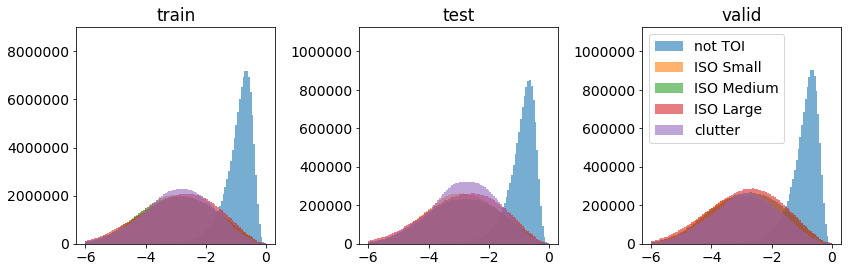

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax = ax.flatten()

for a, data, labels, title in zip(
    ax, 
    [normalized_data_train, normalized_data_test, normalized_data_valid], 
    [labels_train, labels_test, labels_valid],
    ["train", "test", "valid"]
):
#     data = np.stack(data, 0)
    for j in range(n_class):
        inds = labels == j
        a.hist(np.log10(np.abs(data[inds, :, :, :])+eps).flatten(), 100, color=f"C{j}", alpha=0.6)
        a.set_title(title)
        a.set_ylim([0, data.shape[0]*1.1e3])

ax[2].legend(list(class_dict.values()))
plt.tight_layout()

## plot some sample data

In [34]:
pos = np.swapaxes(pos.reshape(ncycles, mnum.max()+1, 3), 0, 1)

In [310]:
dind = 21
d = data_train[dind]

print(f"class: {class_dict[labels_train[dind]]}, data shape: {d.shape}")

params_train.iloc[dind]

class: ISO Small, data shape: (165, 15, 27)


label              1.000000
depth              0.455281
x                  0.997197
y                  2.443726
z                 -0.455281
yaw                4.650188
pitch              2.905616
roll               4.563893
noise_amplitude    0.002603
polarizations      5.000000
clutter_type       0.000000
Name: 21, dtype: float64

In [311]:
# tx_num, rx_num, rx_comp, rxcube
sensor_table = sensorinfo.measNum2TxRxRxcCube()

In [312]:
len(sensor_table)

165

Text(0.5, 0.92, 'Transmitter 4, Target 21: ISO Small')

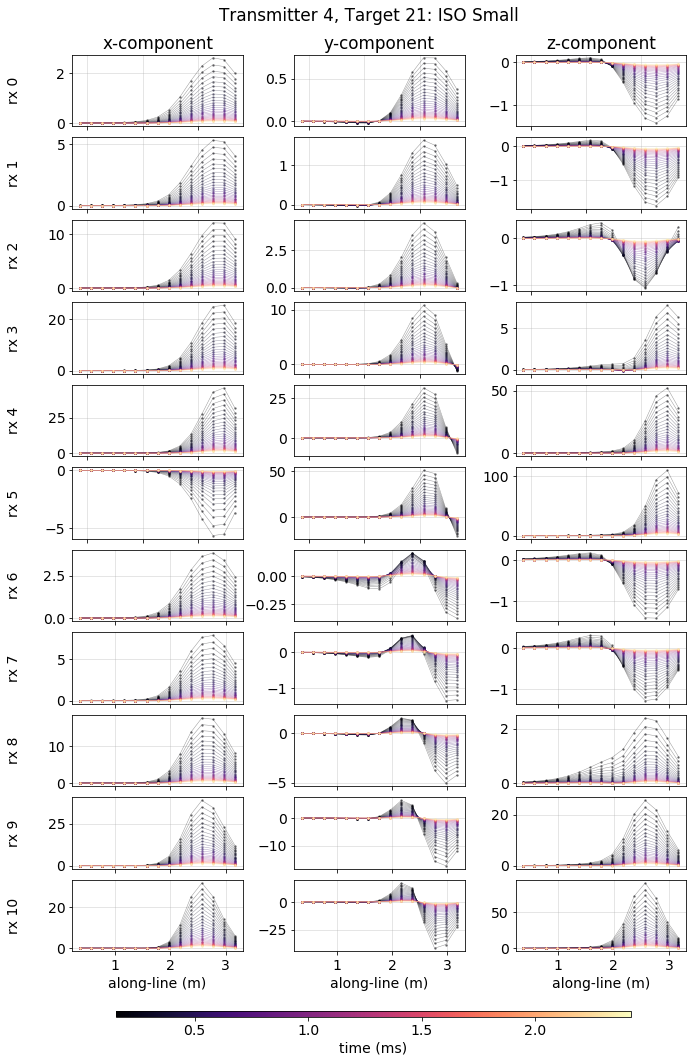

In [315]:
nrx = 11
fig, ax = plt.subplots(nrx, 3, figsize=(11, 1.5*nrx))
fig.subplots_adjust(wspace=0.3, hspace=0.15)

plot_tx = 3
tx_inds = (sensor_table[:, 0] == plot_tx)

cm = plt.get_cmap('magma')
c_norm = Normalize(vmin=times.min(), vmax=times.max())
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

d = data_clean_train[dind][:, :, :]

for rx in range(nrx):
    ii = tx_inds & (sensor_table[:, 3] == rx)
    for a, comp in zip(ax[rx, :], [0, 1, 2]):
        mnumind = np.where( ii & (sensor_table[:, 2] == comp))[0][0]
        for t in range(len(times)):
            a.plot(
                pos[mnumind, :, 1], d[mnumind, :, t], 
                color=scalar_map.to_rgba(times[t]), marker=".", lw=0.5, alpha=0.4, ms=3
            )

        a.grid(which="both", alpha=0.4)
        if rx < nrx-1:
            a.set_xticklabels('')
        else:
            a.set_xlabel("along-line (m)")
        
        if rx == 0:
            if comp == 0:
                a.set_title("x-component")
            elif comp == 1:
                a.set_title("y-component")
            elif comp == 2:
                a.set_title("z-component")
        
        if comp == 0:
            a.set_ylabel(f"rx {rx}")
            a.yaxis.set_label_coords(-0.3, 0.5)
            
# plt.tight_layout()
cbar_ax = fig.add_axes([0.18, 0.07, 0.65, 0.005])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (ms)')

fig.suptitle(f"Transmitter {plot_tx+1}, Target {dind}: {class_dict[labels_train[dind]]}", y=0.92)


In [39]:
# nrx = 11
# fig, ax = plt.subplots(nrx, 3, figsize=(11, 1.5*nrx))
# fig.subplots_adjust(wspace=0.3, hspace=0.15)

# plot_tx = 0
# tx_inds = (sensor_table[:, 0] == plot_tx)

# d = scaled_data_train[dind]

# for rx in range(nrx):
#     ii = tx_inds & (sensor_table[:, 3] == rx)
#     plotme = d[mnumind, :, :].T
#     for a, comp in zip(ax[rx, :], [0, 1, 2]):
#         mnumind = np.where( ii & (sensor_table[:, 2] == comp))[0][0]
#         out = a.pcolormesh(
#             pos[mnumind, :, 1], times, 
#             plotme, cmap="RdBu", vmin=-(np.abs(plotme.max())).max(), vmax=(np.abs(plotme.max())).max()
#         )

# #         a.grid(which="both", alpha=0.4)
# #         a.set_aspect(1)
#         if rx < nrx-1:
#             a.set_xticklabels('')
#         else:
#             a.set_xlabel("along-line (m)")
        
#         if rx == 0:
#             if comp == 0:
#                 a.set_title("x-component")
#             elif comp == 1:
#                 a.set_title("y-component")
#             elif comp == 2:
#                 a.set_title("z-component")
        
#         if comp == 0:
#             a.set_ylabel(f"rx {rx}")
#             a.yaxis.set_label_coords(-0.3, 0.5)

# cbar_ax = fig.add_axes([0.18, 0.07, 0.65, 0.005])
# cb = plt.colorbar(out, cbar_ax, orientation="horizontal")
# cb.set_label('signal')

# fig.suptitle(f"Transmitter {plot_tx+1}, Target {dind}: {class_dict[labels_train[dind]]}", y=0.92)


# build a ConvNet classifier 

In [40]:
# import torch
from torch import nn
from torch.nn import functional

In [41]:
use_scaled = False
use_normalized = True

# normalize_unit = True

if use_scaled is True: 
    X_train = torch.from_numpy(np.float32(np.stack(scaled_data_train, axis=0)))
    X_test = torch.from_numpy(np.float32(np.stack(scaled_data_test, axis=0)))
    X_valid = torch.from_numpy(np.float32(np.stack(scaled_data_valid, axis=0)))

elif use_normalized is True: 
    X_train = torch.from_numpy(np.float32(normalized_data_train))
    X_test = torch.from_numpy(np.float32(normalized_data_test))
    X_valid = torch.from_numpy(np.float32(normalized_data_valid))

else: 
    X_train = torch.from_numpy(np.float32(np.stack(data_train, axis=0)))
    X_test = torch.from_numpy(np.float32(np.stack(data_test, axis=0)))
    X_valid = torch.from_numpy(np.float32(np.stack(data_valid, axis=0)))

C_train = torch.from_numpy(np.float32(labels_train)).long()
C_test = torch.from_numpy(np.float32(labels_test)).long()
C_valid = torch.from_numpy(np.float32(labels_valid)).long()

In [42]:
class ConvNet(nn.Module):
    
    def __init__(self, network_geometry):
        super().__init__()
        self.network_geometry=network_geometry
        self.nt = len(network_geometry)
        self.batch_norm = nn.BatchNorm2d(network_geometry[0])
    
    def forward(self, X, K, batch_norm, bias=None): 
        X = self.batch_norm(X)
        if bias is None:
            bias = [None]*len(K)
        for i, Ki, bn, b in zip(range(self.nt), K, batch_norm, bias):
            z = functional.conv2d(X, Ki, stride=1, padding=1, bias=b)
            z = bn(z)
            z = functional.relu(z)
            z = functional.max_pool2d(z, 3, stride=1, padding=1)
            X = z
        return X

In [43]:
in_channels = 165
# n_class = 4
layer_geometries = [in_channels, 33, 11] #11, 11, 11]
nlayers = len(layer_geometries)
initial_scaling = 1e-3

width = nloc//ntx
ntimes = len(times)

# initialize K's and batch normalizations
K = []
batch_norm = []
bias = None #[]
for i in range(nlayers-1):
    n_in = layer_geometries[i]
    n_out = layer_geometries[i+1]
    Ki = nn.Parameter(torch.Tensor(n_out, n_in, 3, 3))
    Ki.data = torch.randn(n_out, n_in, 3, 3)  * initial_scaling
    K.append(Ki)
    
#     bi = nn.Parameter(torch.Tensor(n_out))
#     bi.data = torch.randn(n_out) * initial_scaling
#     bias.append(bi)
    
    batch_norm.append(nn.BatchNorm2d(n_out))

# initialize classifier W
coarsening = (len(layer_geometries)  - 1)*0
W = nn.Parameter(torch.Tensor(layer_geometries[-1]*(width-coarsening)*(ntimes-coarsening), n_class))
W.data = torch.randn(layer_geometries[-1]*(width-coarsening)*(ntimes-coarsening), n_class)*initial_scaling

b = nn.Parameter(torch.randn(n_class)*initial_scaling, requires_grad=True)

In [44]:
net = ConvNet(layer_geometries)

In [45]:
# run the network

with torch.no_grad():
    out = net(X_train, K, batch_norm, bias)

In [46]:
loss_func = nn.CrossEntropyLoss()

def classify(X, W, b): 
    n = W.shape
    X = X.view(-1, n[0])
    S = torch.matmul(X, W) + b.unsqueeze(0)
    S = functional.softmax(S, dim=1)
    _, C = torch.max(S, axis=1)
    return C, S

def misfit(X, W, b, C):
    n = W.shape
    X = X.view(-1, n[0])
    S = torch.matmul(X, W) + b.unsqueeze(0)

    probs = functional.softmax(S, dim=1)
    return loss_func(S, C), probs

In [47]:
n_parout = (
    np.sum(np.array([np.prod(Ki.shape) for Ki in K])) + np.prod(W.shape) #  + np.sum(np.array([np.prod(bi.shape) for bi in bias]))
)

print('Total number of parameters', n_parout)
print('Total number of data', labels_train.shape[0])

Total number of parameters 74547
Total number of data 8192


In [48]:
def accuracy(S, labels):
    _, predicted = torch.max(S, dim=1)
    total = np.prod(labels.size())
    correct = (predicted == labels).sum().item()
    return correct/total

In [49]:
loss, probs = misfit(out, W, b, C_train)
print('Initial loss = ', loss.detach().numpy())    
print(f'Check:log({n_class}) = ', np.log(n_class))

print(f"\nInitial accuracy: {accuracy(probs, C_train)}")
print(f"Check random    : {1/n_class}")

Initial loss =  1.6024255
Check:log(5) =  1.6094379124341003

Initial accuracy: 0.2171630859375
Check random    : 0.2


In [50]:
batch_size = 32

In [51]:
import torch.optim as optim
optimizer = optim.SGD(
    [{'params': W}, {'params':b}, {'params': K}], #, {'params': bias}], 
    lr = 0.25, momentum=0
)
# lr_cooling = 0.5

In [52]:
running_loss_train = []
running_loss_test = []
running_accuracy_train = []
running_accuracy_test = []

In [53]:
Kopt = None
Wopt = None
bopt = None

for epoch in range(10):  # loop over the dataset multiple times

    # zero the parameter gradients
    g = 0.0
    loss = 0.0
    ind = 0
    
    while ind < X_train.shape[0]:    
        optimizer.zero_grad()
        # get the inputs
        inputs = X_train[ind:ind+batch_size, :, :, :]
        labels = C_train[ind:ind+batch_size]

        # forward 
        x = net(inputs, K, batch_norm, bias)
        lossi, _ = misfit(x, W, b, labels)
        if i==0:
            loss = lossi
        else:
            loss += lossi
        lossi.backward()
        optimizer.step()
        ind += batch_size
    
#     if np.mod(epoch, 4) == 0 and epoch > 0: 
#         print("cooling lr")
#         for opt_param in optim.param_groups:
#             opt_paral["lr"] *= lr_cooling
        
    with torch.no_grad():
        xtest = net(X_test, K, batch_norm, bias)
        loss_test, probs_test = misfit(xtest, W, b, C_test)

        xtrain = net(X_train, K, batch_norm, bias)
        loss_train, probs_train = misfit(xtrain, W, b, C_train)

        accuracy_train = accuracy(probs_train, C_train)
        accuracy_test = accuracy(probs_test, C_test)

        g = torch.norm(W.grad) + sum([torch.norm(Ki.grad) for Ki in K]) + torch.norm(b.grad)

        running_loss_train.append(loss_train)
        running_loss_test.append(loss_test)
        running_accuracy_train.append(accuracy_train)
        running_accuracy_test.append(accuracy_test)
     
        print(f'{epoch:3d}  {loss:2.3e}  {loss_test:2.3e} {g:2.3e} {accuracy_train:0.3f}  {accuracy_test:0.3f}')

print('Finished Training')

  0  3.169e+03  1.050e+00 8.563e-01 0.471  0.475
  1  2.701e+02  8.867e-01 1.444e+00 0.589  0.588
  2  1.997e+02  5.220e-01 2.155e+00 0.819  0.833
  3  1.543e+02  3.192e-01 9.430e-01 0.900  0.898
  4  9.950e+01  2.231e-01 7.559e-01 0.930  0.938
  5  6.493e+01  1.652e-01 3.845e-01 0.954  0.952
  6  4.668e+01  1.143e-01 3.897e-01 0.969  0.962
  7  4.011e+01  1.062e-01 1.025e+00 0.975  0.968
  8  3.931e+01  9.252e-02 4.393e-01 0.981  0.973
  9  1.917e+01  8.127e-02 2.735e-01 0.987  0.979
Finished Training


In [54]:
# training set
x_train_net = net(X_train, K, batch_norm, bias)
_, probs_train = misfit(x_train_net, W, b, C_train)
_, pred_train = torch.max(probs_train, dim=1)

# test set
x_test_net = net(X_test, K, batch_norm, bias)
_, probs_test = misfit(x_test_net, W, b, C_test)
_, pred_test = torch.max(probs_test, dim=1)

# validation set
x_valid_net = net(X_valid, K, batch_norm, bias)
_, probs_valid = misfit(x_valid_net, W, b, C_valid)
_, pred_valid = torch.max(probs_valid, dim=1)

In [55]:
print(f"training accuracy: {accuracy(probs_train, C_train):1.4f}")
print(f"test accuracy    : {accuracy(probs_test, C_test):1.4f}")
print(f"valid accuracy   : {accuracy(probs_valid, C_valid):1.4f}")

training accuracy: 0.9869
test accuracy    : 0.9795
valid accuracy   : 0.9824


In [56]:
# see where it struggled

def get_mislabeled(S, labels):
    _, predicted = torch.max(S, dim=1)
    incorrect = (predicted != labels)
    return incorrect.numpy()

In [57]:
mislabeled_train = get_mislabeled(probs_train, C_train)
mislabeled_test = get_mislabeled(probs_test, C_test)
mislabeled_valid = get_mislabeled(probs_valid, C_valid)

_, pred_labels_train = torch.max(probs_train, dim=1)
_, pred_labels_test = torch.max(probs_test, dim=1)
_, pred_labels_valid = torch.max(probs_valid, dim=1)

print(f"Mislabeled. train: {mislabeled_train.sum()}, test: {mislabeled_test.sum()}, valid: {mislabeled_valid.sum()}")

Mislabeled. train: 107, test: 21, valid: 18


In [58]:
def confusion_matrix(true_labels, predicted_labels):
    n = len(np.unique(true_labels))
    M = np.zeros((n, n), dtype=int)
    for i in range(n):
        for j in range(n):
            M[i, j] = sum((true_labels == i) & (predicted_labels == j))
    return M

In [59]:
print(f"rows = True: {class_dict.values()}")
print(f"cols = Pred: {class_dict.values()}")

rows = True: dict_values(['not TOI', 'ISO Small', 'ISO Medium', 'ISO Large', 'clutter'])
cols = Pred: dict_values(['not TOI', 'ISO Small', 'ISO Medium', 'ISO Large', 'clutter'])


In [60]:
confusion_matrix(C_train, pred_labels_train)

array([[1625,    0,    0,    0,    0],
       [   0, 1569,    0,    0,   19],
       [   0,    0, 1557,   34,   19],
       [   0,    0,    4, 1674,   23],
       [   0,    1,    7,    0, 1660]])

In [61]:
confusion_matrix(C_test, pred_labels_test)

array([[192,   0,   0,   0,   0],
       [  0, 199,   0,   0,   2],
       [  0,   0, 176,   7,   2],
       [  0,   0,   2, 209,   3],
       [  1,   0,   4,   0, 227]])

In [62]:
confusion_matrix(C_valid, pred_labels_valid)

array([[204,   0,   0,   0,   0],
       [  0, 189,   1,   0,   6],
       [  0,   0, 203,   4,   3],
       [  0,   0,   2, 225,   1],
       [  0,   0,   1,   0, 185]])

In [63]:
inds, vals = torch.max(probs_valid[mislabeled_valid, :], dim=0)

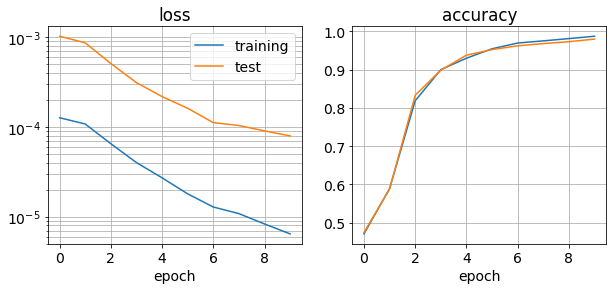

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].semilogy(1/len(data_train) * np.array(running_loss_train), label="training")
ax[0].semilogy(1/len(data_test) * np.array(running_loss_test), label="test")
ax[0].set_title("loss")
ax[0].legend()

ax[1].plot(running_accuracy_train, label="training")
ax[1].plot(running_accuracy_test, label="test")
ax[1].set_title("accuracy")

for a in ax:
    a.grid(which="both")
    a.set_xlabel("epoch")

## look at features in network 

In [65]:
ind = 6

print(probs_train[ind, :])
print(f"class: {class_dict[labels_train[ind]]}")

params_train.iloc[ind]

tensor([1., 0., 0., 0., 0.], grad_fn=<SliceBackward>)
class: not TOI


label              0.000000
depth              0.000000
x                  1.208228
y                  0.565538
z                 -0.000000
yaw                5.486218
pitch              2.344794
roll               2.618872
noise_amplitude    0.000552
polarizations      0.000000
clutter_type       0.000000
Name: 6, dtype: float64

In [66]:
X_train.shape, len(K)

(torch.Size([8192, 165, 15, 27]), 2)

In [67]:
Z0 = []
Z1 = []
Z2 = []
Z3 = []
with torch.no_grad():
    X = X_train[ind:ind+1, :, :, :]
    for Ki, bn in zip(K, batch_norm):
        print(Ki.shape)
        z0 = functional.conv2d(X, Ki, stride=1, padding=1)
        z1 = bn(z0)
        z2 = functional.relu(z1)
        z3 = functional.max_pool2d(z2, 3, stride=1, padding=1)
        X = z2
        Z0.append(z0)
        Z1.append(z1)
        Z2.append(z2)
        Z3.append(z3)

torch.Size([33, 165, 3, 3])
torch.Size([11, 33, 3, 3])


In [68]:
K[1].shape

torch.Size([11, 33, 3, 3])

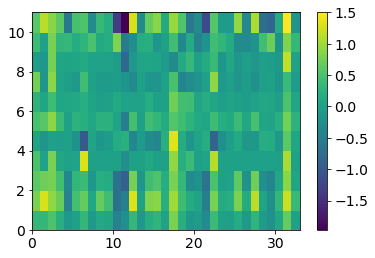

In [69]:
plt.colorbar(plt.pcolormesh(K[1][:, :, 2, 1].data.numpy()))

tensor(-2.1546) tensor(2.1546)


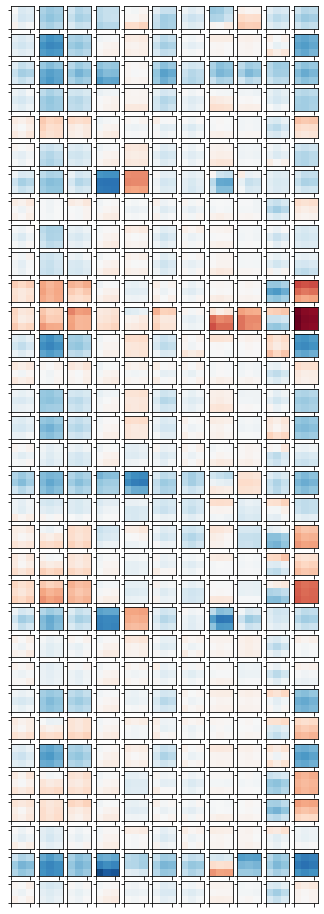

In [70]:
fig, ax = plt.subplots(33, 11, figsize = (11*0.5, 33*0.5))

plotme = K[1].detach()
vmax=np.abs(plotme.flatten()).max()
vmin=-vmax
print(vmin, vmax)

for i in range(33):
    for j in range(11):
        a = ax[i, j]
        a.set_xticklabels('')
        a.set_yticklabels('')
        a.pcolormesh(plotme[j, i, :, :], vmin=vmin, vmax=vmax, cmap="RdBu")
# K[1].shape

In [71]:
bias

In [72]:
W.shape

torch.Size([4455, 5])

In [73]:
# nfeatures = 33
# fig, ax = plt.subplots(11, 3, figsize=(11, 1.5*11))
# fig.subplots_adjust(wspace=0.3, hspace=0.15)

# cm = plt.get_cmap('magma')
# c_norm = Normalize(vmin=times.min(), vmax=times.max())
# scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
# scalar_map.set_array([])

# plot_me = Z2[0][0, :, :, :]

# for i, a in enumerate(ax.flatten()):
#     for t in range(plot_me.shape[-1]):
#         a.plot(
#             plot_me[i, :, t], 
#             color=scalar_map.to_rgba(times[t]), marker=".", lw=0.5, alpha=0.4, ms=3
#         )

#         a.grid(which="both", alpha=0.4)
#         if rx < nrx-1:
#             a.set_xticklabels('')
            
# # plt.tight_layout()
# cbar_ax = fig.add_axes([0.18, 0.07, 0.65, 0.005])
# cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
# cb.set_label('time (ms)')

In [74]:
# nfeatures = 11
# fig, ax = plt.subplots(11, 1, figsize=(4, 1.5*11))
# fig.subplots_adjust(wspace=0.3, hspace=0.15)

# cm = plt.get_cmap('magma')
# c_norm = Normalize(vmin=times.min(), vmax=times.max())
# scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
# scalar_map.set_array([])

# plot_me = Z2[1][0, :, :, :]

# for i, a in enumerate(ax.flatten()):
#     for t in range(plot_me.shape[-1]):
#         a.plot(
#             plot_me[i, :, t], 
#             color=scalar_map.to_rgba(times[t]), marker=".", lw=0.5, alpha=0.4, ms=3
#         )

#         a.grid(which="both", alpha=0.4)
#         if rx < nrx-1:
#             a.set_xticklabels('')
            
# # plt.tight_layout()
# cbar_ax = fig.add_axes([0.18, 0.07, 0.65, 0.005])
# cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
# cb.set_label('time (ms)')

In [75]:
w_plot = []
with torch.no_grad():
    for i in range(n_class):
        w_plot.append(W[:, i].view(Z2[1].shape).detach())

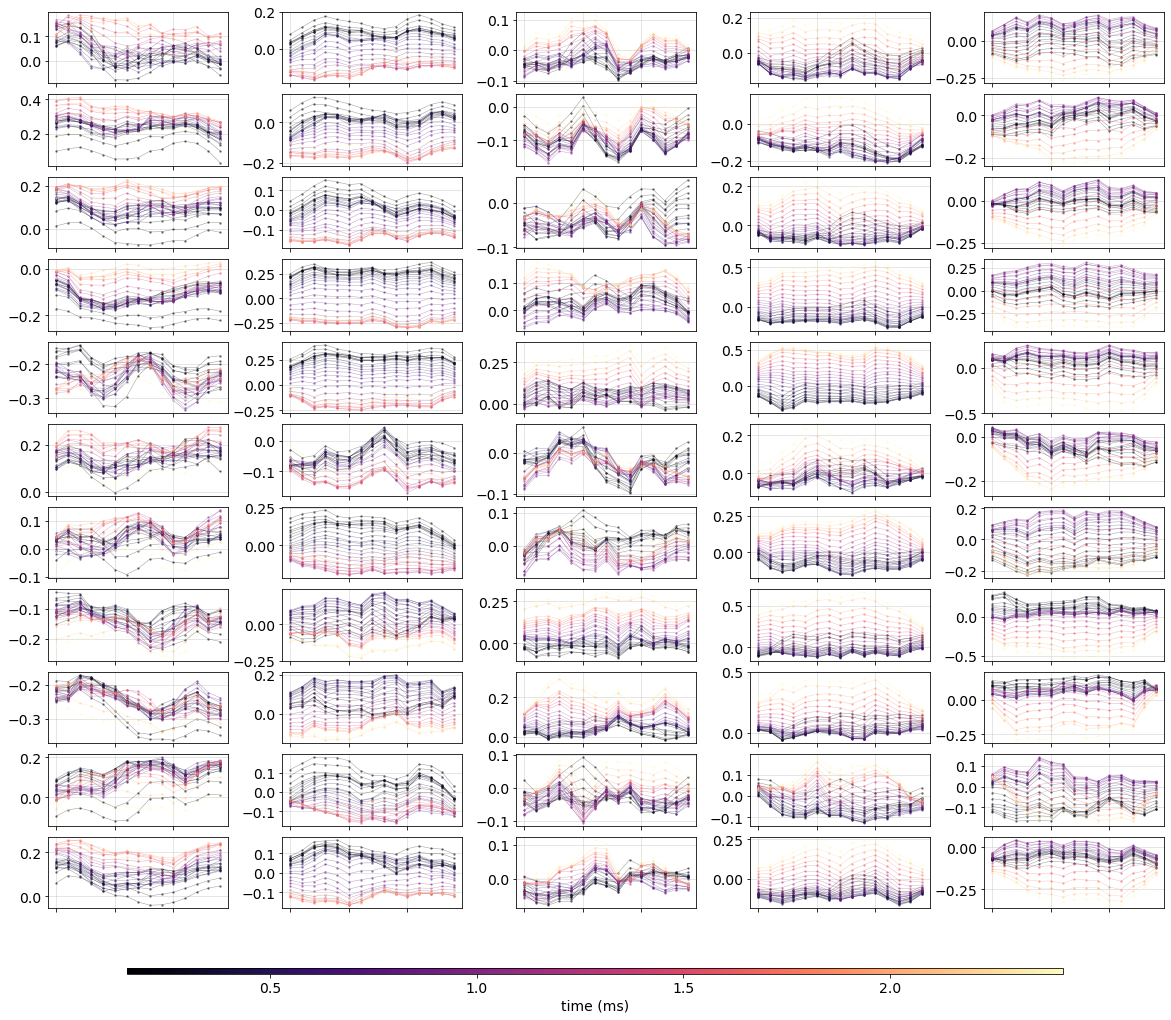

In [76]:
nfeatures = 11
fig, ax = plt.subplots(11, len(w_plot), figsize=(4*len(w_plot), 1.5*11))
fig.subplots_adjust(wspace=0.3, hspace=0.15)

cm = plt.get_cmap('magma')
c_norm = Normalize(vmin=times.min(), vmax=times.max())
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

for ii, w in enumerate(w_plot):
    for i, a in enumerate(ax[:, ii]):
        for t in range(w.shape[-1]):
            a.plot(
                w[0, i, :, t], 
                color=scalar_map.to_rgba(times[t]), marker=".", lw=0.5, alpha=0.4, ms=3
            )

            a.grid(which="both", alpha=0.4)
            if ii < nfeatures-1:
                a.set_xticklabels('')
            
# plt.tight_layout()
cbar_ax = fig.add_axes([0.18, 0.07, 0.65, 0.005])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (ms)')

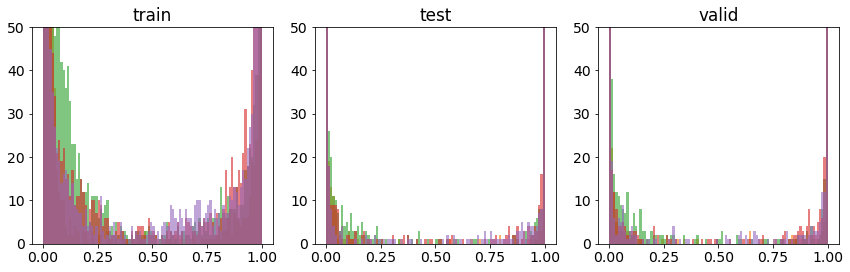

In [77]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax = ax.flatten()

for a, probs, title in zip(ax, [probs_train, probs_test, probs_valid], ["train", "test", "valid"]):
    a.set_title(title)
    for i in range(n_class):
        a.hist(probs[:, i].detach().numpy(), 100, color=f"C{i}", alpha=0.6)

        a.set_ylim([0, 50])
# ax[0].legend([class_dict[0], class_dict[1], class_dict[2]])
plt.tight_layout()

# generate a line of data

In [78]:
ymax_profile = 40
nloc_profile = int(ymax_profile/dy)
ncycles_profile = int(nloc_profile/ntx)

y_profile = np.linspace(0, ymax_profile-dy, nloc_profile)
x_profile = np.zeros(nloc_profile)
z_profile = 0.28 * np.ones(nloc_profile)

pitch_profile = np.zeros(nloc_profile)
roll_profile = np.zeros(nloc_profile)
yaw_profile = np.zeros(nloc_profile)  # moving north (sensor in typical orientation)

txnum_profile = np.kron(np.ones(ncycles_profile), np.arange(ntx))

In [79]:
# Convert sensor location coordinates to Rx locations
pos_profile, mnum_profile = sensorCoords2RxCoords(
    sensorinfo=sensorinfo,
    x = x_profile, 
    y = y_profile, 
    z = z_profile, 
    pitch = pitch_profile, 
    roll = roll_profile, 
    yaw = yaw_profile,
    txnum = txnum_profile
)

pitch_profile = np.concatenate([np.tile(x,pos_profile[i].shape[0]) for i,x in enumerate(pitch_profile)])
roll_profile = np.concatenate([np.tile(x,pos_profile[i].shape[0]) for i,x in enumerate(roll_profile)])
yaw_profile = np.concatenate([np.tile(x,pos_profile[i].shape[0]) for i,x in enumerate(yaw_profile)])
pos_profile = np.concatenate(pos_profile,axis=0)

In [80]:
depths_profile = np.r_[0.1, 0.2, 0.4, 0.2, 0.4, 0.6]
params_profile = pd.DataFrame({
    "label": [1, 1, 1, 2, 2, 2],
    "depth": depths_profile,
    "x": np.r_[0, 0, 0, 0, 0, 0],
    "y": np.r_[2.5, 10, 17, 22, 27, 32],
    "z": -depths_profile,
    "yaw": 0*np.r_[0, np.pi/4, np.pi, 0, np.pi/4, np.pi/2],
    "pitch": np.r_[0, 0, 0, 0, 0, 0],
    "roll": np.r_[0, 0, 0, 0, 0, 0],
    "noise_amplitude": 0.005*np.r_[1, 1, 1, 1, 1, 1],
    "polarizations": [0, 0, 0, 0, 0, 0],
    "clutter_type": np.zeros(len(depths_profile))
})
params_profile

,label,depth,x,y,z,yaw,pitch,roll,noise_amplitude,polarizations,clutter_type
0,1,0.1,0,2.5,-0.1,0.0,0,0,0.005,0,0.0
1,1,0.2,0,10.0,-0.2,0.0,0,0,0.005,0,0.0
2,1,0.4,0,17.0,-0.4,0.0,0,0,0.005,0,0.0
3,2,0.2,0,22.0,-0.2,0.0,0,0,0.005,0,0.0
4,2,0.4,0,27.0,-0.4,0.0,0,0,0.005,0,0.0
5,2,0.6,0,32.0,-0.6,0.0,0,0,0.005,0,0.0


In [81]:
# figuring out where all of the vertices are in coordinate system -- gives us location of vertices 
Tx_indices_rot_profile, Rx_indices_rot_profile = preCalcLoopCorners(
    sensorinfo=sensorinfo, mnum=mnum_profile, rlist=pos_profile, pitch=pitch_profile, roll=roll_profile, yaw=yaw_profile
) 

# convienence object for inputs to fwd modelling 
st_profile = FModParam(sensorinfo, pos_profile, mnum_profile, times, Tx_indices_rot_profile, Rx_indices_rot_profile)  



In [82]:
data_profile, noise_profile = run_simulations(params_profile, st=st_profile, mnum=mnum_profile, ncycles=ncycles_profile)

In [83]:
data_profile = [d + n for d, n in zip(data_profile, noise_profile)]
data_profile[0].shape

(165, 200, 27)

In [84]:
X_profile = pos_profile[:, 0].reshape((165, ncycles_profile), order="F")
Y_profile = pos_profile[:, 1].reshape((165, ncycles_profile), order="F")


In [85]:
D_profile = sum(data_profile)
D_profile.shape

(165, 200, 27)

In [86]:
window_width_profile = int(ymax/y_spacing)
w_step_profile = 5
n_windows_profile = (X_profile.shape[1]-window_width_profile)//w_step_profile
print(n_windows_profile)

37


In [87]:
n = D_profile.shape
net_data_profile = np.zeros((n_windows_profile, n[0], window_width_profile, n[2]))
net_y_profile = np.zeros((n_windows_profile, n[0], window_width_profile))
net_x_profile = np.zeros((n_windows_profile, n[0], window_width_profile))

for i in range(n_windows_profile):
    inds = slice(i*w_step_profile,i*w_step_profile+window_width_profile)
    net_x_profile[i, :, :] = X_profile[:, inds]
    net_y_profile[i, :, :] = Y_profile[:, inds]
    net_data_profile[i, :, :, :] = D_profile[:, inds, :]

In [88]:
if use_scaled is True or use_normalized is True:
    print("scaling by time")
    net_data_profile_torch = net_data_profile*time_scaling
else:
    net_data_profile_torch = net_data_profile
    
if use_normalized is True:
    print("normalizing")
    net_data_profile_torch = normalize_data(net_data_profile_torch)

net_data_profile_torch = torch.from_numpy(np.float32(net_data_profile_torch))

scaling by time
normalizing


In [89]:
with torch.no_grad():
    out_field = net(net_data_profile_torch, K, batch_norm, bias)
    labels_profile, probs_profile = classify(out_field, W, b)

In [90]:
from matplotlib.lines import Line2D

(-2, 8)

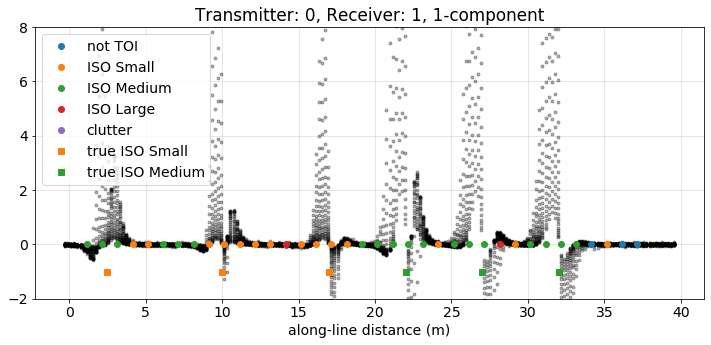

In [91]:
mnum_plot = 12
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

ordnance_labels = [
    Line2D(
        [0], [0], marker='o', color="w", 
        markerfacecolor=f'C{int(key)}', markeredgecolor=f'C{int(key)}', 
        label=value
    ) for key, value in class_dict.items()
]

ordnance_labels = ordnance_labels + [
    Line2D(
        [0], [0], marker='s', color="w", 
        markerfacecolor=f'C{int(key)}', markeredgecolor=f'C{int(key)}', 
        label=f"true {class_dict[key]}"
    ) for key in [1, 2]
]

ax.plot(Y_profile[mnum_plot, :], D_profile[mnum_plot, :, :], '.', color="k", alpha=0.3)
ax.grid("both", alpha=0.4)

for i in range(net_data_profile.shape[0]):
    y_plot = np.mean(net_y_profile[i, mnum_plot, :])
    ax.plot(y_plot, 0, f'C{labels_profile[i]}o')

txnumplot = sensor_table[mnum_plot, 0]
rxnumplot = sensor_table[mnum_plot, 3]
rxcompplot = sensor_table[mnum_plot, 2]
ax.set_title(f"Transmitter: {txnumplot}, Receiver: {rxnumplot}, {rxcompplot}-component")
ax.set_xlabel("along-line distance (m)")

for i in range(len(depths_profile)):
    label = params_profile["label"][i]
    ax.plot(params_profile["y"][i], -1, f"sC{label}")

ax.legend(handles=ordnance_labels)

# ax.set_xlim([12.5, 17.5])
ax.set_ylim([-2, 8])


In [92]:
probs_profile

tensor([[5.8135e-34, 9.6538e-02, 9.0291e-01, 8.9538e-06, 5.4333e-04],
        [6.2700e-31, 1.2296e-01, 8.7688e-01, 2.9147e-09, 1.6053e-04],
        [5.5963e-28, 3.2579e-01, 6.5382e-01, 2.8134e-06, 2.0379e-02],
        [5.6696e-24, 9.1256e-01, 8.4882e-02, 9.6163e-07, 2.5551e-03],
        [1.7316e-21, 1.0000e+00, 5.4727e-23, 0.0000e+00, 3.5842e-10],
        [3.0797e-06, 1.2678e-17, 1.0000e+00, 5.6922e-14, 4.7944e-28],
        [8.3400e-22, 2.1739e-01, 3.9394e-01, 2.7816e-01, 1.1052e-01],
        [3.3023e-23, 9.8199e-02, 9.0029e-01, 3.3581e-06, 1.5083e-03],
        [4.8277e-32, 9.5237e-01, 3.2189e-02, 5.9551e-18, 1.5444e-02],
        [1.7036e-41, 9.7231e-01, 1.3285e-03, 1.1303e-20, 2.6358e-02],
        [2.9633e-13, 9.9850e-01, 1.8027e-04, 1.6435e-14, 1.3169e-03],
        [4.5359e-22, 9.9345e-01, 1.2792e-04, 2.7820e-10, 6.4214e-03],
        [1.0469e-33, 1.0000e+00, 4.2282e-25, 0.0000e+00, 1.2434e-21],
        [1.5743e-19, 3.4058e-02, 2.4322e-01, 5.9851e-01, 1.2422e-01],
        [5.0352e-25,

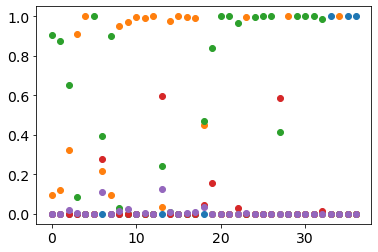

In [93]:
for i in range(n_class):
    plt.plot(probs_profile[:, i], 'o')

# load up a line from the test site

In [94]:
data_directory = "../UXO_protected/data-blacktusk"
groundtruth = pd.read_excel(os.path.sep.join([data_directory, "groundtruth_Testplot5F.xlsx"]), nrows=93)

In [95]:
# H5 functions
def proc_attr(inp):
    """HDF5 - Process attributes for the input group and return them in a dictionary."""
    dic = {}
    for att in inp.attrs.keys():
        if inp.attrs[att].dtype.char == 'S':
            dic[att] = [x.strip() for x in inp.attrs[att].tostring().decode('ascii').split(',')]
        else:
            dic[att] = inp.attrs[att][0] if isinstance(inp.attrs[att],np.ndarray) and inp.attrs[att].size==1 else inp.attrs[att]
    return dic
    pass

def proc_group(inp):
    """HDF5 - A recursive function for reading datasets and attributes into a dictionary."""
    dic = {}
    dic.update(proc_attr(inp))
    for key in inp.keys():
        if isinstance(inp[key], h5py.Group):
            dic.update({key:proc_group(inp[key])})
        else:
            dic[key] = inp[key][()]
        pass
    return dic

In [96]:
dfile = os.path.join(data_directory, 'Testplot5F.h5')
f = h5py.File(dfile, 'r')
dic = proc_group(f)
f.close()

In [97]:
# Generate the sensorinfo structure
sensor_name = dic['SensorName'][0]
sensor_config = dic['SensorConfig'][0]
afile = os.path.join(code_dir,'config','sensor_definitions','{}___{}.yaml'.format(sensor_name,sensor_config))
sensorinfo = SensorInfo.fromYAML(afile)[0]

print(sensor_name)

UltraTEMArrayNA


In [98]:
raw_data_keys = [
    't154', 't171', 't190', 't211', 't235', 't262', 't292', 't325', 't361', 
    't401', 't446', 't496', 't551', 't613', 't681', 't758', 't842', 't936', 
    't1040', 't1156', 't1286', 't1429', 't1588', 't1764', 't1961', 't2178', 't2420' 
]

In [99]:
xyz_dict = dic["XYZ"]
ch = xyz_dict['Info']['ChannelNames']
datai = xyz_dict['Info']['Data']['ChannelIndex'].flatten().astype(int)-1 # These are indices to the decay data
yawi = int(xyz_dict['Info']['Yaw']['ChannelIndex'])-1 # index to the yaw channel
pitchi = int(xyz_dict['Info']['Pitch']['ChannelIndex'])-1 
rolli = int(xyz_dict['Info']['Roll']['ChannelIndex'])-1 
mni = int(xyz_dict["Info"]["MeasNum"]["ChannelIndex"])-1
easting = int(xyz_dict["Info"]["Easting"]["ChannelIndex"])-1
northing = int(xyz_dict["Info"]["Northing"]["ChannelIndex"])-1
linesi = int(xyz_dict["Info"]["Line"]["ChannelIndex"])-1
rx_num = int(xyz_dict["Info"]["RxNum"]["ChannelIndex"])-1
tx_num = int(xyz_dict["Info"]["TxNum"]["ChannelIndex"])-1
rx_comp = int(xyz_dict["Info"]["RxCNum"]["ChannelIndex"])-1
rx_num = int(xyz_dict["Info"]["RxNum"]["ChannelIndex"]) - 1

times = np.array(dic['SensorTimes'].flatten())
print(times.min(), times.max(), len(times))

0.154 2.42 27


In [100]:
use_raw = False
if use_raw:
    datai = np.array([i for i in range(len(ch)) if ch[i] in raw_data_keys])

In [101]:
datai

array([54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79, 80])

In [102]:
xyz_data = xyz_dict["Data"]
mn = xyz_data[mni, :].astype(int) - 1

In [103]:
line_id = 1004 #, 1013]
line_inds = xyz_data[linesi, :] == line_id
print(sum(line_inds))

60390


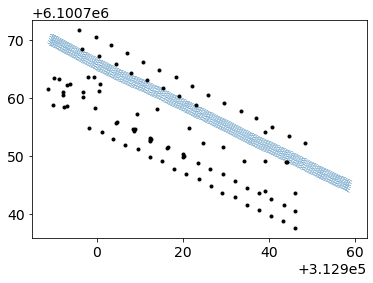

In [104]:
fig, ax = plt.subplots(1, 1)
ax.plot(xyz_data[easting, line_inds], xyz_data[northing, line_inds], '.', alpha=0.1, ms=0.2)
ax.plot(groundtruth["Easting"], groundtruth["Northing"], 'k.')

In [105]:
from scipy import stats

In [106]:
# local coordinates for the data set 
x0, y0 = np.mean(xyz_data[easting, :]), np.mean(xyz_data[northing, :])
local_easting = xyz_data[easting, :] - x0
local_northing = xyz_data[northing, :] - y0

slope, intercept, _, _, _ = stats.linregress(local_easting, local_northing)
print(slope, intercept)

-0.3486944749895923 6.346738382583072e-10


In [107]:
theta = np.arctan(slope)+np.pi/2
local_x = np.cos(theta) * local_easting + np.sin(theta) * local_northing
local_y = -np.sin(theta) * local_easting + np.cos(theta) * local_northing


local_ground_truth_easting = np.array(groundtruth["Easting"] - x0)
local_ground_truth_northing = np.array(groundtruth["Northing"] - y0)
local_ground_truth_x = np.cos(theta) * local_ground_truth_easting + np.sin(theta) * local_ground_truth_northing
local_ground_truth_y = -np.sin(theta) * local_ground_truth_easting + np.cos(theta) * local_ground_truth_northing


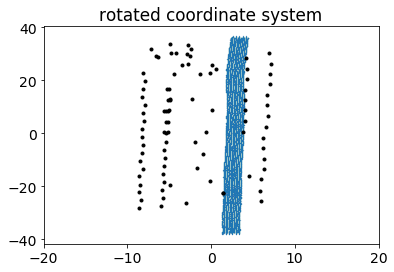

In [108]:
line_x = local_x[line_inds]
line_y = local_y[line_inds]

mn_line = mn[line_inds]
fig, ax = plt.subplots(1, 1)
ax.plot(line_x, line_y, '.', ms=0.1)
ax.set_xlim(np.r_[-20, 20])
ax.set_title("rotated coordinate system")

ax.plot(local_ground_truth_x, local_ground_truth_y, 'k.', label="ordnance")

In [109]:
ord_inds_covered = (
    (local_ground_truth_x >= line_x.min()) & (local_ground_truth_x <= line_x.max()) &
    (local_ground_truth_y >= line_y.min()) & (local_ground_truth_y <= line_y.max())
)

Text(0, 0.5, 'y (m)')

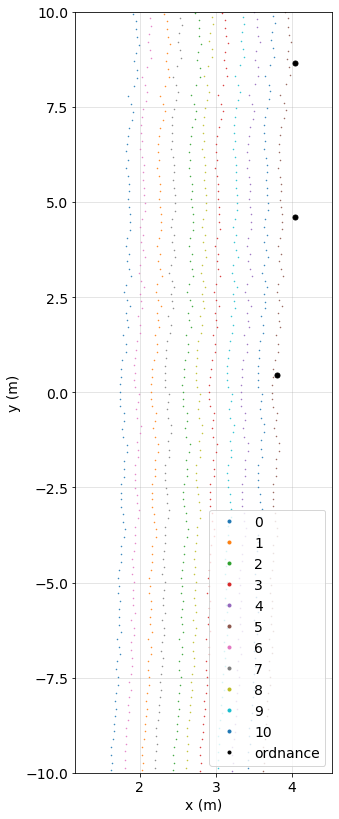

In [110]:
mn_line = mn[line_inds]
fig, ax = plt.subplots(1, 1, figsize=(8, 14))

for plot_mn in range(11):

    plot_inds = (mn_line==plot_mn)
    ax.plot(line_x[plot_inds], line_y[plot_inds], '.', ms=1, label=plot_mn)

ax.plot(
    local_ground_truth_x[ord_inds_covered], local_ground_truth_y[ord_inds_covered], 'k.', label="ordnance", ms=10
)
lgnd = ax.legend()
[h._legmarker.set_markersize(6) for h in lgnd.legendHandles]

# ax.set_xlim([-12, -2])
ax.set_ylim([-10, 10])
ax.grid("both", alpha = 0.4)
ax.set_aspect(0.5)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")

In [111]:
pos[1, :, :]

array([[-0.59, -0.25,  0.28],
       [-0.59, -0.05,  0.28],
       [-0.59,  0.15,  0.28],
       [-0.59,  0.35,  0.28],
       [-0.59,  0.55,  0.28],
       [-0.59,  0.75,  0.28],
       [-0.59,  0.95,  0.28],
       [-0.59,  1.15,  0.28],
       [-0.59,  1.35,  0.28],
       [-0.59,  1.55,  0.28],
       [-0.59,  1.75,  0.28],
       [-0.59,  1.95,  0.28],
       [-0.59,  2.15,  0.28],
       [-0.59,  2.35,  0.28],
       [-0.59,  2.55,  0.28]])

In [112]:
# target data shape 165 X nlocs X nTimes 
# grab by measurement number 
# then re-stack

x_locs = []
y_locs = []
data_list = []
line_data = xyz_data[datai, :][:, line_inds]

for mnind in range(mn.max() + 1):
    mninds = mn_line == mnind
    x_locs.append(line_x[mninds])
    y_locs.append(line_y[mninds])
    data_list.append(line_data[:, mninds].T)

In [113]:
X_locs = np.vstack(x_locs)
Y_locs = np.vstack(y_locs)
S_data = np.stack(data_list, axis=0)
print(S_data.shape, X_locs.shape)

(165, 366, 27) (165, 366)


In [114]:
np.unique(groundtruth["ItemBuried"])

array(['20mm', 'EOD9115', 'EOD9145', 'EOD9146', 'EOD9147', 'EOD9148',
       'EOD9149', 'EOD9150', 'EOD9151', 'EOD9152', 'EOD9153', 'EOD9154',
       'EOD9156', 'EOD9157', 'EOD9160', 'East 5m', 'Large ISO',
       'Medium ISO', 'Native1', 'Native12', 'Native2', 'Native3',
       'Native4', 'Native5', 'Native8', 'North 5m', 'Railway',
       'Small ISO', 'South 5m', 'West 5m'], dtype=object)

In [115]:
# make a representative synthetic 
# grab 1/3 of the objects

synthetic_keys = ["20mm", "Small ISO", "Medium ISO", "Large ISO"]
# synthetic_starts_with = ["Native"]

In [116]:
synthetic_ground_truth = {}
synthetic_easting = []
synthetic_northing = []
synthetic_x = []
synthetic_y = []
synthetic_item = []
synthetic_depth = []

for i, item in enumerate(groundtruth["ItemBuried"]):
    if item in synthetic_keys or item.startswith("Native"):
        synthetic_easting.append(groundtruth["Easting"][i])
        synthetic_northing.append(groundtruth["Northing"][i])
        synthetic_x.append(local_ground_truth_x[i])
        synthetic_y.append(local_ground_truth_y[i])
        
        d = groundtruth["Depth (m)"][i]
        if np.isnan(d):
            d = 0.3 
        synthetic_depth.append(d)
        
        if item.startswith("Native"):
            synthetic_item.append("Small ISO")
        else: 
            synthetic_item.append(item)

synthetic_ground_truth = {
    "easting": np.array(synthetic_easting),
    "northing": np.array(synthetic_northing),
    "x": np.array(synthetic_x), 
    "y": np.array(synthetic_y), 
    "depth": np.array(synthetic_depth),
    "item": np.array(synthetic_item)
}

In [117]:
synthetic_subset = {
    key: val[::4] for key, val in synthetic_ground_truth.items()
}

In [118]:
synthetic_subset

{'easting': array([312923.52500037, 312932.06074307, 312940.47638096, 312898.08382408,
        312906.56175157, 312915.03260126, 312923.61117537, 312932.16153953,
        312940.41850804, 312895.72381807, 312907.01475844, 312918.24701987,
        312929.50477658, 312940.57282116, 312896.51966552, 312907.94876645,
        312919.15160998, 312908.48438097, 312919.86435242, 312924.64900128,
        312929.36937323, 312899.49118043, 312896.70669918, 312892.11643525,
        312891.18629538]),
 'northing': array([6100748.80876635, 6100745.59413476, 6100742.48645651,
        6100754.82838281, 6100751.76793813, 6100749.0491326 ,
        6100745.96523236, 6100742.9240195 , 6100739.53826276,
        6100771.61173835, 6100767.71841953, 6100763.57973463,
        6100759.08867369, 6100754.9632093 , 6100768.36009218,
        6100764.31793086, 6100760.35364184, 6100754.33153566,
        6100749.85789358, 6100752.14121046, 6100751.55088464,
        6100758.29670431, 6100760.19617624, 6100760.41765144

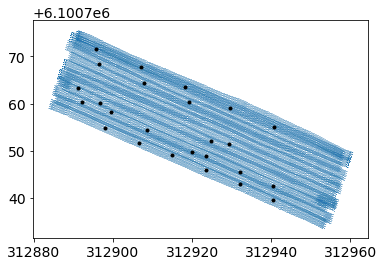

In [119]:
fig, ax = plt.subplots(1, 1)
ax.plot(xyz_data[easting], xyz_data[northing], '.', alpha=0.1, ms=0.2)
ax.plot(synthetic_subset["easting"], synthetic_subset["northing"], 'k.')

In [120]:
# generate synthetic data

In [249]:
label = []
depth = []
x = []
y = []
yaw = []
pitch = []
roll = []
polarizations = []


for i, item in enumerate(synthetic_subset["item"]):
    if item in ["Small ISO", "Native"]:
        label.append(1)
    elif item == "Medium ISO":
        label.append(2)
    elif item == "Large ISO":
        label.append(3)
    elif item == "20mm":
        label.append(4)
    else: 
        print(item)
    polarizations.append(0)
    yaw.append(0)
    pitch.append(0)
    roll.append(0)

params_synthetic = pd.DataFrame({
    "label": np.array(label),
    "depth": synthetic_subset["depth"],
    "x": synthetic_subset["x"],
    "y": synthetic_subset["y"],
    "z": -synthetic_subset["depth"],
    "yaw": np.zeros(len(label)),
    "pitch": np.zeros(len(label)),
    "roll": np.zeros(len(label)),
    "noise_amplitude": 5e-2*np.ones(len(label)),
    "polarizations": polarizations,
})

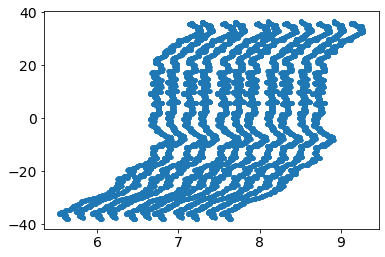

In [250]:
line_inds = xyz_data[linesi, :] == line_id
x_line = local_x[line_inds]
y_line = local_y[line_inds]
plt.plot(x_line, y_line, '.')

In [251]:
sum(line_inds)/165

393.0

In [252]:
# make the synthetic local locations

pos_synthetic = []
mnum_synthetic = []
yaw_synthetic = []
lines_synthetic = []

for line_id in np.unique(xyz_data[linesi, :]): 
    line_inds = xyz_data[linesi, :] == line_id
    ncycles = int(np.ceil(line_inds.sum()/165))
    x_line = np.mean(local_x[line_inds])
    y0i = np.min(local_y[line_inds])
    nloc = int(ncycles * ntx)
    
    xi = np.ones(nloc)*x_line
    yi = y_spacing/ntx * np.arange(0, nloc) + y0i
    zi = 0.28 * np.ones(nloc)

    pitchi = np.zeros(nloc)
    rolli = np.zeros(nloc)
    if np.mean(xyz_data[linesi, :]) < 0:
        yawi = np.zeros(nloc)  # moving north (sensor in typical orientation)
    else: # moving south 
        yawi = np.pi*np.ones(nloc)

    txnumi = np.kron(np.ones(ncycles), np.arange(int(ntx)))

    posi, mnumi = sensorCoords2RxCoords(
        sensorinfo=sensorinfo,
        x = xi, 
        y = yi, 
        z = zi, 
        pitch = pitchi, 
        roll = rolli, 
        yaw = yawi,
        txnum = txnumi
    )
    
    yaw_synthetic.append(yawi)
    pos_synthetic.append(posi)
    mnum_synthetic.append(mnumi)
    lines_synthetic.append(line_id*np.ones_like(yawi))

In [253]:
pos_synthetic = np.vstack(pos_synthetic)
mnum_synthetic = np.hstack(mnum_synthetic)
yaw_synthetic = np.hstack(yaw_synthetic)
lines_synthetic = np.hstack(lines_synthetic)



In [254]:
yaw_synthetic = np.concatenate([np.tile(x,pos_synthetic[i].shape[0]) for i,x in enumerate(yaw_synthetic)])
lines_synthetic = np.concatenate([np.tile(x,pos_synthetic[i].shape[0]) for i,x in enumerate(lines_synthetic)])
pos_synthetic = np.concatenate(pos_synthetic,axis=0)

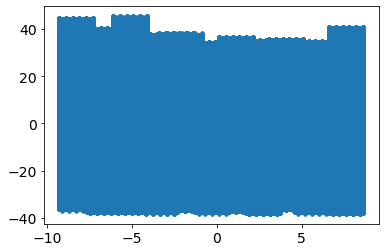

In [255]:
plt.plot(pos_synthetic[:, 0], pos_synthetic[:, 1], '.')

In [256]:
# mnum_synthetic = xyz_data[mni, :].astype(int) - 1
# pos_synthetic = np.hstack([local_x[:, None], local_y[:, None], 0.28*np.ones((len(mnum_synthetic),1))])

Tx_indices_rot, Rx_indices_rot = preCalcLoopCorners(
    sensorinfo=sensorinfo, mnum=mnum_synthetic, rlist=pos_synthetic, 
    pitch=np.zeros_like(yaw_synthetic), 
    roll=np.zeros_like(yaw_synthetic), 
    yaw=yaw_synthetic
) 

# convienence object for inputs to fwd modelling 
st_synthetic = FModParam(sensorinfo, pos_synthetic, mnum_synthetic, times, Tx_indices_rot, Rx_indices_rot)  

In [257]:
def generate_synthetic_data(parameters, st, mnum):
    data = None
    noise_data = None
    for i, l in enumerate(parameters["label"]):
        print(f"{i}: simulating {l}")
        xyz = np.r_[parameters["x"][i], parameters["y"][i], parameters["z"][i]]
        ypr = np.r_[parameters["yaw"][i], parameters["pitch"][i], parameters["roll"][i]]
        pi = parameters["polarizations"][i]

        if class_dict[l] != "clutter":
            L3 = ordnance[class_dict[l]]["L3"][pi]
            L2 = ordnance[class_dict[l]]["L2"][pi]
            L1 = ordnance[class_dict[l]]["L1"][pi]
        else:
            clutter_name = "20mm"
            L3 = ordnance[clutter_name]["L3"][pi]
            L2 = ordnance[clutter_name]["L2"][pi]
            L1 = ordnance[clutter_name]["L1"][pi]

        mod = Model(xyz=xyz, gba=ypr, l3=L3, l2=L2, l1=L1, times=times)
        V = forwardWithQ(mod, st) # mV
        if np.isnan(V).any():
            print(i)
            raise Exception 
        
    #     n = V.shape()
    #     V = V.reshape(ncycles, mnum.max()+1, len(times))
    #     V = np.swapaxes(V, 0, 1)
        noisy_V = (
            V + 
            np.random.randn(np.prod(V.shape)).reshape(V.shape) * 
            noise_model(times, amplitude=parameters["noise_amplitude"][i])
        )
        if data is None:
            data = V
            noise_data = noisy_V
        else:
            data = data + V
            noise_data = noise_data + noisy_V
    return data, noise_data

In [258]:
params_synthetic.loc[19]

label              1.000000
depth              0.300000
x                 -1.907584
y                 -3.276515
z                 -0.300000
yaw                0.000000
pitch              0.000000
roll               0.000000
noise_amplitude    0.050000
polarizations      0.000000
Name: 19, dtype: float64

In [259]:
synthetic_data, synthetic_data_noisy = generate_synthetic_data(
    params_synthetic, st_synthetic, mnum_synthetic
)

0: simulating 4
1: simulating 4
2: simulating 4
3: simulating 1
4: simulating 1
5: simulating 1
6: simulating 1
7: simulating 1
8: simulating 1
9: simulating 2
10: simulating 2
11: simulating 2
12: simulating 2
13: simulating 2
14: simulating 3
15: simulating 3
16: simulating 3
17: simulating 1
18: simulating 2
19: simulating 1
20: simulating 1
21: simulating 1
22: simulating 2
23: simulating 4
24: simulating 1


In [270]:
window_width = int(ymax/y_spacing)
w_step = 10

In [271]:
def classify_data(local_pos, mn, data, lines):
    classified_X = []
    classified_Y = []
    classified_probs = []
    classified_classes = []

    for line_id in np.unique(xyz_data[linesi, :]): 
        line_inds = lines == line_id

        x_locs = []
        y_locs = []
        data_list = []
        line_data = data[:, line_inds]
        mn_line = mn[line_inds]
        line_x = local_pos[line_inds, 0]
        line_y = local_pos[line_inds, 1]

        min_mn_num = np.inf
        for mnind in range(mn.max() + 1):    
            mninds = mn_line == mnind
            if mninds.sum() < min_mn_num:
                min_mn_num = mninds.sum()
            x_locs.append(line_x[mninds])
            y_locs.append(line_y[mninds])
            data_list.append(line_data[:, mninds].T)

        X_locs = np.vstack([x[:min_mn_num] for x in x_locs])
        Y_locs = np.vstack([y[:min_mn_num] for y in y_locs])
        S_data = np.stack([d[:min_mn_num, :] for d in data_list], axis=0)

        n_windows = (X_locs.shape[1]-window_width)//w_step + 1
        print(line_id, window_width, w_step, n_windows, X_locs.shape)

        n = S_data.shape
        net_data = np.zeros((n_windows, n[0], window_width, n[2]))
        net_y = np.zeros((n_windows, n[0], window_width))
        net_x = np.zeros((n_windows, n[0], window_width))

        for i in range(n_windows):
            inds = slice(i*w_step,i*w_step+window_width)
            net_x[i, :, :] = X_locs[:, inds]
            net_y[i, :, :] = Y_locs[:, inds]
            net_data[i, :, :, :] = S_data[:, inds, :]

        if use_scaled or use_normalized:
            net_data = net_data * time_scaling

        if use_normalized:
            net_data = normalize_data(net_data)

        net_data_torch = torch.from_numpy(np.float32(net_data))

        with torch.no_grad():
            out_field = net(net_data_torch, K, batch_norm, bias)
            classes_field, probs_field = classify(out_field, W, b)

        classified_X.append(net_x)
        classified_Y.append(net_y)
        classified_probs.append(probs_field.numpy())
        classified_classes.append(classes_field.numpy())
    return {
        "x": classified_X,
        "y": classified_Y,
        "probs": np.vstack(classified_probs),
        "classes": np.hstack(classified_classes)
    }

In [272]:
classify_clean = classify_data(pos_synthetic, mnum_synthetic, synthetic_data.T, lines_synthetic)
classify_noisy = classify_data(pos_synthetic, mnum_synthetic, synthetic_data_noisy.T, lines_synthetic)

1001.0 15 10 34 (165, 345)
1002.0 15 10 35 (165, 363)
1003.0 15 10 35 (165, 360)
1004.0 15 10 36 (165, 366)
1005.0 15 10 36 (165, 369)
1006.0 15 10 35 (165, 361)
1007.0 15 10 1 (165, 21)
1008.0 15 10 36 (165, 374)
1009.0 15 10 2 (165, 29)
1010.0 15 10 37 (165, 378)
1011.0 15 10 40 (165, 405)
1012.0 15 10 38 (165, 390)
1013.0 15 10 40 (165, 405)
1014.0 15 10 38 (165, 393)
1001.0 15 10 34 (165, 345)
1002.0 15 10 35 (165, 363)
1003.0 15 10 35 (165, 360)
1004.0 15 10 36 (165, 366)
1005.0 15 10 36 (165, 369)
1006.0 15 10 35 (165, 361)
1007.0 15 10 1 (165, 21)
1008.0 15 10 36 (165, 374)
1009.0 15 10 2 (165, 29)
1010.0 15 10 37 (165, 378)
1011.0 15 10 40 (165, 405)
1012.0 15 10 38 (165, 390)
1013.0 15 10 40 (165, 405)
1014.0 15 10 38 (165, 393)


In [273]:
look_at = classify_noisy
synthetic_X_means = np.hstack([cx.mean(1).mean(1) for cx in look_at["x"]])
synthetic_Y_means = np.hstack([cy.mean(1).mean(1) for cy in look_at["y"]])

synthetic_eastings  = np.cos(theta) * synthetic_X_means - np.sin(theta) * synthetic_Y_means + x0 
synthetic_northings = np.sin(theta) * synthetic_X_means + np.cos(theta) * synthetic_Y_means + y0

In [274]:
look_at["classes"].shape

(443,)

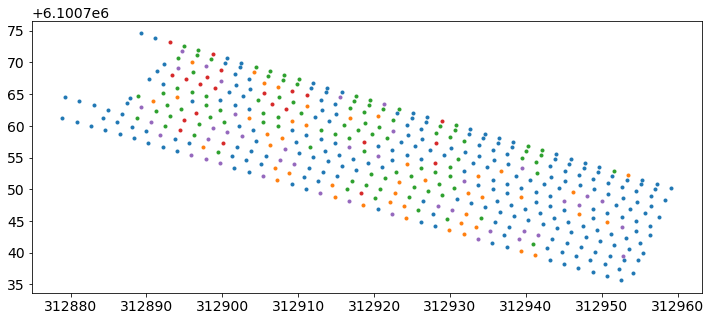

In [275]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
for key, val in class_dict.items():
    inds = look_at["classes"] == key
    ax.plot(
        synthetic_eastings[inds], synthetic_northings[inds], f"C{key}o", ms=3, label=val
    )

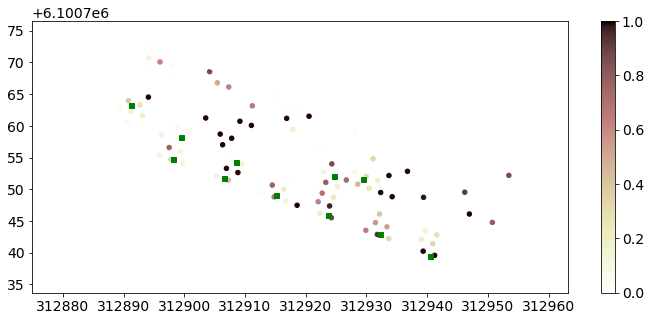

In [276]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

plt.colorbar(ax.scatter(
    synthetic_eastings, synthetic_northings, c=classify_noisy["probs"][:, 1], marker='o', 
    cmap="pink_r", vmin=0.0, vmax=1, s=20
    ), 
    ax=ax
)

for i, item in enumerate(synthetic_subset["item"]):
    if item == "Small ISO":
        ax.plot(synthetic_subset["easting"][i], synthetic_subset["northing"][i], 'gs', ms=5)
#     elif item == "Medium ISO": 
#         ax.plot(synthetic_subset["easting"][i], synthetic_subset["northing"][i], 'k^', ms=5)
#     elif item == "Large ISO":
#         ax.plot(synthetic_subset["easting"][i], synthetic_subset["northing"][i], 'kv', ms=5)
#     elif item == "20mm":
#         ax.plot(synthetic_subset["easting"][i], synthetic_subset["northing"][i], 'kd', ms=5)

In [277]:
from matplotlib.colors import Normalize

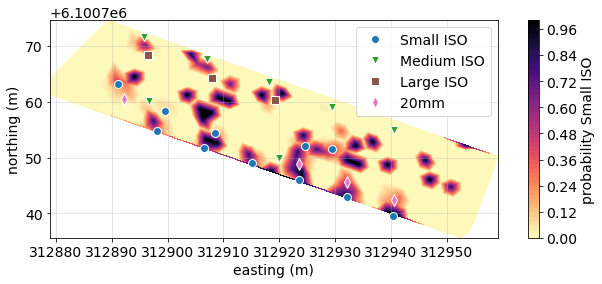

In [278]:
from scipy.spatial import Delaunay

fig, ax = plt.subplots(1, 1, figsize=(11, 4))

# Create triangulation.
import matplotlib.tri as triag
tri = Delaunay(np.hstack([synthetic_eastings[:, None], synthetic_northings[:, None]]))
# tri = triag.Triangulation(synthetic_eastings, synthetic_northings)

# cm = Normalize(vmin=0, vmax=1)
# scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)

cm = plt.get_cmap('magma_r')
c_norm = Normalize(vmin=0., vmax=1.)
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])


cb = plt.colorbar(ax.tricontourf(
    tri.points[:, 0], tri.points[:, 1],
    classify_noisy["probs"][:, 1], 50,
    cmap="magma_r", vmin=0., vmax=1
#     norm=cm
    ), 
    ax=ax,
)
# cb.set_clim([0.3, 1])

ax.set_aspect(1)
ax.grid(which="both", alpha=0.4)

for i, item in enumerate(synthetic_subset["item"]):
    if item == "Small ISO":
        ax.plot(synthetic_subset["easting"][i], synthetic_subset["northing"][i], 'C0o', ms=8, mec="w")
    elif item == "Medium ISO": 
        ax.plot(synthetic_subset["easting"][i], synthetic_subset["northing"][i], 'C2v', ms=8, mec="w")
    elif item == "Large ISO":
        ax.plot(synthetic_subset["easting"][i], synthetic_subset["northing"][i], 'C5s', ms=8, mec="w")
    elif item == "20mm":
        ax.plot(synthetic_subset["easting"][i], synthetic_subset["northing"][i], 'C6d', ms=8, mec="w")

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], c="w", marker='o', ms=8, mec="w", mfc='C0'),
                Line2D([0], [0], c="w", marker="v", ms=8, mec="w", mfc='C2'),
                Line2D([0], [0], c="w", marker='s', ms=8, mec="w", mfc='C5'),
                Line2D([0], [0], c="w", marker='d', ms=8, mec="w", mfc='C6'),
               ]

ax.legend(custom_lines, ["Small ISO", "Medium ISO", "Large ISO", "20mm"])
ax.set_xlabel("easting (m)")
ax.set_ylabel("northing (m)")
cb.set_label("probability Small ISO")

In [1]:
import verde as vd

coordinates = (synthetic_eastings, synthetic_northings)
spacing = 0.5

fig, ax = plt.subplots(1, 1, figsize=(11, 4))

chain = vd.Chain([
    ("mean", vd.BlockMean(np.median, spacing=spacing)),
    ("spline", vd.Spline(classify_noisy["probs"][:, 1])),
])
print(chain)

chain.fit(coordinates, classify_noisy["probs"][:, 1])

region = vd.get_region(coordinates)

grid = chain.grid(
    region=region,
    spacing=spacing, 
    dims=["easting (m)", "northing (m)"],
    data_names=["prob_small_iso"]
)



# grid_full = chain.grid(
#     region=region, 
#     spacing=spacing,
#     dims=["easting", "northing"]
# )
# grid = vd.distance_mask(
#     (synthetic_eastings, synthetic_northings),
#     maxdist = 1,
#     grid=grid_full
# )

cm = plt.get_cmap('magma_r')
c_norm = Normalize(vmin=0., vmax=1.)
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

pc = grid.prob_small_iso.pcolormesh(ax=ax, vmin=0, vmax=1, cmap=cm)

# cb = plt.colorbar(ax.tricontourf(
#     tri.points[:, 0], tri.points[:, 1],
#     classify_noisy["probs"][:, 1], 50,
#     cmap="magma_r", vmin=0., vmax=1
# #     norm=cm
#     ), 
#     ax=ax,
# )
# cb.set_clim([0.3, 1])

ax.set_aspect(1)
ax.grid(which="both", alpha=0.4)

for i, item in enumerate(synthetic_subset["item"]):
    if item == "Small ISO":
        ax.plot(synthetic_subset["easting"][i], synthetic_subset["northing"][i], 'C0o', ms=8, mec="w")
    elif item == "Medium ISO": 
        ax.plot(synthetic_subset["easting"][i], synthetic_subset["northing"][i], 'C2v', ms=8, mec="w")
    elif item == "Large ISO":
        ax.plot(synthetic_subset["easting"][i], synthetic_subset["northing"][i], 'C5s', ms=8, mec="w")
    elif item == "20mm":
        ax.plot(synthetic_subset["easting"][i], synthetic_subset["northing"][i], 'C6d', ms=8, mec="w")

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], c="w", marker='o', ms=8, mec="w", mfc='C0'),
                Line2D([0], [0], c="w", marker="v", ms=8, mec="w", mfc='C2'),
                Line2D([0], [0], c="w", marker='s', ms=8, mec="w", mfc='C5'),
                Line2D([0], [0], c="w", marker='d', ms=8, mec="w", mfc='C6'),
               ]

ax.legend(custom_lines, ["Small ISO", "Medium ISO", "Large ISO", "20mm"])
ax.set_xlabel("easting (m)")
ax.set_ylabel("northing (m)")
cb.set_label("probability Small ISO")

NameError: name 'synthetic_eastings' is not defined

In [269]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 5))

# plt.colorbar(ax.triplot(
#     synthetic_eastings, synthetic_northings, c=classify_noisy["probs"][:, 1], marker='o', 
#     cmap="Reds", vmin=0.0, vmax=1, s=20, alpha=0.8
#     ), 
#     ax=ax
# )

# for i, item in enumerate(synthetic_subset["item"]):
#     if item == "Small ISO":
#         ax.plot(synthetic_subset["easting"][i], synthetic_subset["northing"][i], 'ks', ms=5)
# #     elif item == "Medium ISO": 
# #         ax.plot(synthetic_subset["easting"][i], synthetic_subset["northing"][i], 'k^', ms=5)
# #     elif item == "Large ISO":
# #         ax.plot(synthetic_subset["easting"][i], synthetic_subset["northing"][i], 'kv', ms=5)
# #     elif item == "20mm":
# #         ax.plot(synthetic_subset["easting"][i], synthetic_subset["northing"][i], 'kd', ms=5)

# True data

In [141]:
# window_width = int(ymax/y_spacing)
# w_step = 5
# n_windows = (X_locs.shape[1]-window_width)//w_step + 1
# print(window_width, w_step, n_windows)

In [142]:
# n = S_data.shape
# net_data = np.zeros((n_windows, n[0], window_width, n[2]))
# net_y = np.zeros((n_windows, n[0], window_width))
# net_x = np.zeros((n_windows, n[0], window_width))

# for i in range(n_windows):
#     inds = slice(i*w_step,i*w_step+window_width)
#     net_x[i, :, :] = X_locs[:, inds]
#     net_y[i, :, :] = Y_locs[:, inds]
#     net_data[i, :, :, :] = S_data[:, inds, :]

# if use_scaled or use_normalized:
#     net_data = net_data * time_scaling

# if use_normalized:
#     net_data = normalize_data(net_data)

In [143]:
# net_data_torch = torch.from_numpy(np.float32(net_data))

In [144]:
# with torch.no_grad():
#     out_field = net(net_data_torch, K, batch_norm, bias)
#     labels_field, probs_field = classify(out_field, W, b)

In [145]:
# from matplotlib.lines import Line2D

In [146]:
# mnum_plot = 11
# fig, ax = plt.subplots(1, 1, figsize=(12, 4))

# ordnance_labels = [
#     Line2D(
#         [0], [0], marker='o', color="w", 
#         markerfacecolor=f'C{int(key)}', markeredgecolor=f'C{int(key)}', 
#         label=value
#     ) for key, value in class_dict.items()
# ]

# ordnance_labels.append(
#     Line2D(
#         [0], [0], marker='s', color="w", 
#         markerfacecolor=f'C3', markeredgecolor=f'C3', 
#         label="ground truth"
#     )
# )

# ax.plot(y_locs[mnum_plot], data_list[mnum_plot], '.', color="k", alpha=0.3)
# ax.grid("both", alpha=0.4)

# for i in range(net_data.shape[0]):
#     y_plot = np.mean(net_y[i, mnum_plot, :])
#     ax.plot(y_plot, 0, f'C{labels_field[i]}o')

# txnumplot = sensor_table[mnum_plot, 0]
# rxnumplot = sensor_table[mnum_plot, 3]
# rxcompplot = sensor_table[mnum_plot, 2]
# ax.set_title(f"Line: {line_id}, Transmitter: {txnumplot}, Receiver: {rxnumplot}, {rxcompplot}-component")
# ax.set_xlabel("along-line distance (m)")
# ax.plot(local_ground_truth_y[ord_inds_covered], -5*(np.ones(ord_inds_covered.sum())) , "sC6")

# ax.legend(handles=ordnance_labels)

# ax.set_xlim([-20, 0])
# ax.set_ylim([-10, 10])


In [147]:
# plt.plot(probs_field, '.')

In [148]:
# groundtruth["ItemBuried"]

In [149]:
# groundtruth[:][ord_inds_covered]

## classify the whole survey

In [150]:
# unique_lines = np.unique(xyz_data[linesi, :])
# n_lines = len(unique_lines)

In [151]:
# window_width = int(ymax/y_spacing)
# w_step = 2


In [152]:
# classified_X = []
# classified_Y = []
# classified_probs = []
# classified_classes = []

# for line_id in unique_lines: 
#     line_inds = xyz_data[linesi, :] == line_id
    
#     x_locs = []
#     y_locs = []
#     data_list = []
#     line_data = xyz_data[datai, :][:, line_inds]
#     mn_line = mn[line_inds]
#     line_x = local_x[line_inds]
#     line_y = local_y[line_inds]

#     min_mn_num = np.inf
#     for mnind in range(mn.max() + 1):    
#         mninds = mn_line == mnind
#         if mninds.sum() < min_mn_num:
#             min_mn_num = mninds.sum()
#         x_locs.append(line_x[mninds])
#         y_locs.append(line_y[mninds])
#         data_list.append(line_data[:, mninds].T)
    
#     X_locs = np.vstack([x[:min_mn_num] for x in x_locs])
#     Y_locs = np.vstack([y[:min_mn_num] for y in y_locs])
#     S_data = np.stack([d[:min_mn_num, :] for d in data_list], axis=0)
    
#     n_windows = (X_locs.shape[1]-window_width)//w_step + 1
#     print(line_id, window_width, w_step, n_windows, X_locs.shape)
    
#     n = S_data.shape
#     net_data = np.zeros((n_windows, n[0], window_width, n[2]))
#     net_y = np.zeros((n_windows, n[0], window_width))
#     net_x = np.zeros((n_windows, n[0], window_width))

#     for i in range(n_windows):
#         inds = slice(i*w_step,i*w_step+window_width)
#         net_x[i, :, :] = X_locs[:, inds]
#         net_y[i, :, :] = Y_locs[:, inds]
#         net_data[i, :, :, :] = S_data[:, inds, :]

#     if use_scaled or use_normalized:
#         net_data = net_data * time_scaling

#     if use_normalized:
#         net_data = normalize_data(net_data)
        
#     net_data_torch = torch.from_numpy(np.float32(net_data))
    
#     with torch.no_grad():
#         out_field = net(net_data_torch, K, batch_norm, bias)
#         classes_field, probs_field = classify(out_field, W, b)
    
#     classified_X.append(net_x)
#     classified_Y.append(net_y)
#     classified_probs.append(probs_field)
#     classified_classes.append(classes_field)

In [153]:
# classified_X[0].shape

In [154]:
# classified_X_means = np.hstack([cx.mean(1).mean(1) for cx in classified_X])
# classified_Y_means = np.hstack([cy.mean(1).mean(1) for cy in classified_Y])

In [155]:
# classified_eastings  = np.cos(theta) * classified_X_means - np.sin(theta) * classified_Y_means + x0 
# classified_northings = np.sin(theta) * classified_X_means + np.cos(theta) * classified_Y_means + y0

In [156]:
# classified_probs_stack = np.vstack(classified_probs)
# classified_classes_stack = np.hstack(classified_classes)

In [157]:
# fig, ax = plt.subplots(1, 1)

# for key, val in class_dict.items():
#     inds = classified_classes_stack == key
#     ax.plot(
#         classified_eastings[inds], classified_northings[inds], f"C{key}o", ms=3, label=val
#     )


In [158]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 5))

# plt.colorbar(ax.scatter(
#     classified_eastings, classified_northings, c=(classified_probs_stack[:, 1]), marker='o', 
#     cmap="Reds", vmin=0.8, vmax=1, s=10, alpha=0.5
#     ), 
#     ax=ax
# )

# for i, item in enumerate(groundtruth["ItemBuried"]):
#     if item == "Small ISO":
#         ax.plot(groundtruth["Easting"][i], groundtruth["Northing"][i], 'ko', ms=5)
#     elif item.startswith("Native"): 
#         ax.plot(groundtruth["Easting"][i], groundtruth["Northing"][i], 'ks', ms=5)
# #     elif item == "Railway":
# #         ax.plot(groundtruth["Easting"][i], groundtruth["Northing"][i], 'kv', ms=4)
# #     elif item == "Large ISO":
# #         ax.plot(groundtruth["Easting"][i], groundtruth["Northing"][i], 'k^', ms=4)

In [159]:
# plt.plot(classified_probs_stack, '.')

In [160]:
# np.unique(groundtruth["ItemBuried"])

In [161]:
# groundtruth.loc[[i for i, g in enumerate(groundtruth["ItemBuried"]) if g.startswith("Native")]]